<a href="https://colab.research.google.com/github/rodrigoviannini/Machine-Learning/blob/main/Aula_7_KNN_e_ferramentas_especiais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 7 - KNN e ferramentas especiais

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) KNN
- 2) Ferramentas Especiais
- 3) KNN para regressão

____
____
____

## 1) KNN

Hoje conheceremos um novo algoritmo de aprendizagem (que inicialmente veremos no contexto de classificação): o KNN, que é a sigla de **k nearest neighbors**, ou seja, **k vizinhos mais próximos**.

A ideia é bem simples: tomamos uma base de treino classificada (supervisionada). 

A cada observação de teste que queiramos classificar, tomamos **a classe como sendo a classe das $k$ observações que estão mais próximas do elemento a ser classificado**

<img src="https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531424125/KNN_final1_ibdm8a.png" width=600>

Este algoritmo é muito simples e intuitivo, mas há dois elementos de extrema importância:

> Como medir a **distância** entre dados? Qual é a **métrica** adequada?

Veremos que o sklearn nos permite escolher diferentes métricas de distância, o que é ótimo, pois assim podemos seguir a habitual abordagem: testar diferentes métricas, e escolher a que der melhores resultados!

> Qual é o número de vizinhos adequados: i.e., **como escolher $k$?**

Essa é uma escolha particularmente importante, pois escolhas diferentes de $k$ podem facilmente levar a classificações diferentes:

<img src="https://helloacm.com/wp-content/uploads/2016/03/2012-10-26-knn-concept.png" width=400>

Veremos logo como escolher bons valores!

> **Reflita e responda**: como a escolha de $k$ influencia a performance de generalização do modelo (isto é, seu comportamento no que diz respeito ao trade-off viés-variância)?
><br><br>Dica: pense no que acontece nos extremos, $k=1$ e $k=N$, ond $N$ é o número de observações na base de treino.

Conclusão: 

- $k=1$ temos alta variância (overfitting - pense nos outliers!).

- $k=N$ temos alto viés (underfittinf - não aprendemos nada, só predizemos diretamente a classe majoritária na base de treino).

As etapas do algoritmo são as seguintes:

1. Recebe um dado não classificado;
2. Mede sua distância (Euclidiana, Manhattan, Minkowski ou Ponderada) de cada um dos elementos da base de treino;
3. Obtém um *ranking* das distâncias, em ordem decrescente;
4. Verifica a classe de cada da um dos *K* dados que tiveram a menor distância e conta a quantidade de cada classe;
5. Toma como resultado a classe que mais apareceu dentre os dados que tiveram as menores distâncias;
6. Classifica o novo dado com a classe tomada como resultado da classificação.

KNN é um método LAZY LEARNER -- Ou seja, **não há uma etapa explícita de treinamento**, conforme vimos antes.

Cada observação de teste é classificada por vez, segundo o passo a passo acima.

> **MUITO IMPORTANTE**: sempre devemos **escalar os dados** quando formos construir um modelo KNN! Reflita: por quê?

In [ ]:
# importe as principais bibliotecas

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#### Lendo conjunto de dados

Como exemplo vamos utilizar dados de câncer de mama (o dataset que foi sugerido como exercício!), eles estão disponiveis no [UCI](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) ou pelo [kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). 

A ideia é que consigamos construir um modelo para classificar, com base em medidas fisiológicas, se um tumor é maligno ou benigno.

In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

In [ ]:
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

A coluna de ID não dá nenhuma informação relevante: podemos eliminá-la

In [ ]:
df = df.drop(columns="id")

In [ ]:
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [ ]:
# dá pra ver que tem muita diferença de escala nas features! PRECISAMOS NORMALIZAR!!

df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [ ]:
df.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Explore os dados! Essa é uma base muito rica, com muitas colunas! Aproveite este exemplo concreto para fazer muitas perguntas e respondê-las! Faça visualizações sempre que achar interessante!

Vamos fazer um apenas pra treinar:

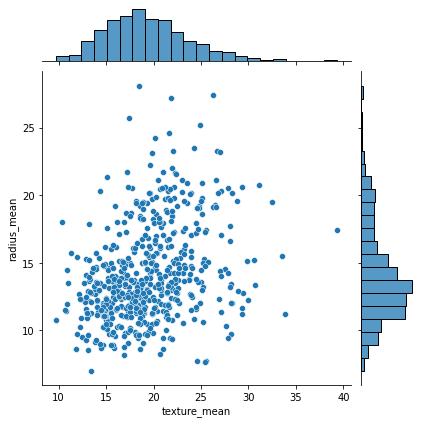

In [ ]:
sns.jointplot(data=df, x="texture_mean", y="radius_mean")

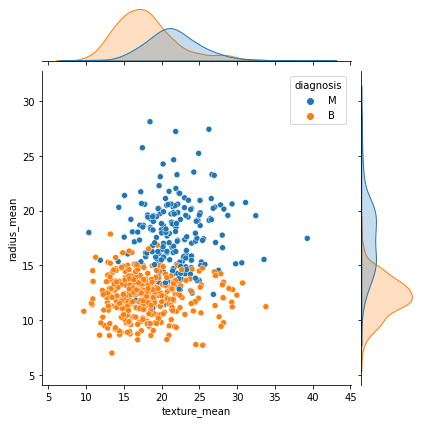

In [ ]:
sns.jointplot(data=df, x="texture_mean", y="radius_mean", hue="diagnosis")

Uma pergunta é bastante importante:

In [ ]:
df["diagnosis"].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [ ]:
df["diagnosis"].value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

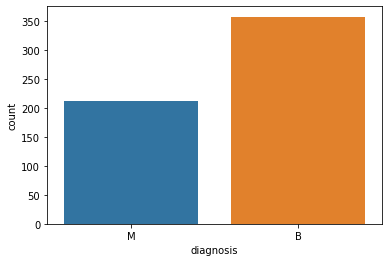

In [ ]:
sns.countplot(data=df, x="diagnosis")

In [ ]:
# isso equivale a usar o k=n

y_pred = df["diagnosis"].value_counts().index[0]

y_pred

'B'

Há um leve desbalanceamento: há mais dados de tumores benignos do que malignos. 

Como o desbalanceamento não é tão gritante assim (coisa de 80-20), e este desbalanço é algo natural, não vamos tratar este caso, vamos deixar para tratar um caso mais crítico.

[Clique aqui](https://machinelearningmastery.com/what-is-imbalanced-classification/) para saber um pouco mais sobre desbalanceamento de classes; e [aqui](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) caso você queira saber algumas formas de endereçar este problema (spoilers!).

Uma coisa importante é sempre setar o parâmetro `stratify` do train-test split, que vai garantir a mesma distribuição do target em ambos os conjuntos de treino e de teste! Isso faz com que a diferença na distribuição não se torne um fator adicional de viés na avaliação do modelo!

In [ ]:
X = df.drop(columns="diagnosis")
y = df["diagnosis"]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y.value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

In [ ]:
# atenção ao stratify!
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)

In [ ]:
y_train.value_counts(normalize=True)

B    0.626374
M    0.373626
Name: diagnosis, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

B    0.631579
M    0.368421
Name: diagnosis, dtype: float64

_____

**Transformando os dados**

O primeiro processo que pode ser feito para tunning do KNN é a **transformação das features**. 

Devido ao KNN utilizar **distâncias** como critério para classificação, ter as variaveis transformadas garante que sejam eliminados viéses relacionados à escala dos dados.

Para **normalizar os dados**, o sklearn nos apresenta a ferramenta [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

É **muito importante** que os transformers sejam fitados **com os dados de treino**, para que informações da base de teste não sejam utilizadas no treinamento (conceito conhecido como [data leakage](https://machinelearningmastery.com/data-preparation-without-data-leakage/)).

No caso do standard scaler: o objetivo do `.fit()` é determinar a média $\mu$ e desvio padrão $\sigma$ dos dados, para que a normalização seja feita. Se calcularmos estes parâmetros usando **todos os dados**, estamos utilizando informações da base de teste -- o que, como sabemos, jamais deve ser feito!!

Por isso, sempre siga o seguinte passo-a-passo par aplicação de transformers:

- Primeiro, faça o train test split;
- Use o `.fit()` nos dados de **treino**;
- Use o `.transform()` pra trasnformar os dados de treino e de teste tbm -- com o **mesmo transformer treinado** com os dados de treino;

Começaremos com o  [standard scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) - **média 0 e std 1**

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

In [ ]:
X_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.166077,19.417692,92.215868,659.578242,0.095993,0.103835,0.089184,0.049015,0.181497,0.062715,...,16.351514,25.904879,107.860484,890.569231,0.132083,0.255529,0.275166,0.115491,0.291364,0.084124
std,3.579081,4.290653,24.717118,360.418686,0.014310,0.053910,0.081698,0.039686,0.027646,0.006971,...,4.901037,6.079532,34.176019,582.346181,0.023481,0.158400,0.212066,0.066844,0.063043,0.018169
min,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,0.050240,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.710000,16.335000,75.235000,420.400000,0.085130,0.063735,0.029520,0.019685,0.162050,0.057635,...,13.020000,21.490000,84.135000,516.150000,0.114550,0.147750,0.119350,0.064075,0.251200,0.071365
50%,13.340000,18.900000,86.180000,546.400000,0.095240,0.092280,0.059400,0.033340,0.179900,0.061300,...,14.920000,25.480000,97.650000,683.400000,0.131100,0.216700,0.229800,0.101000,0.282300,0.080090
75%,15.935000,21.830000,104.500000,795.500000,0.104900,0.130350,0.132200,0.074075,0.195400,0.066370,...,19.185000,30.200000,127.000000,1122.500000,0.146600,0.338100,0.385700,0.162100,0.318700,0.092085
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [ ]:
# tivemos que transformar num dataframe, pq o std scaler retorna arrays do numpy, que não têm o metodo describe

pd.DataFrame(X_train_ss, columns=X_train.columns).describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,...,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02
mean,-1.820278e-16,3.693017e-16,4.958183e-16,-1.049222e-16,1.141944e-16,-2.151972e-16,-1.908120e-16,4.245688e-17,5.368111e-18,9.882205e-18,...,-3.794279e-16,2.318048e-16,-2.820698e-16,-8.784182e-18,-2.200926e-16,-1.156584e-16,-5.856121e-17,-8.052167e-17,-4.902062e-16,-2.577913e-16
std,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,...,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00
min,-2.009730e+00,-2.265011e+00,-1.961360e+00,-1.433461e+00,-2.342455e+00,-1.568307e+00,-1.092835e+00,-1.236420e+00,-2.733834e+00,-1.791603e+00,...,-1.720204e+00,-2.286387e+00,-1.682868e+00,-1.212587e+00,-2.596976e+00,-1.442492e+00,-1.298977e+00,-1.729670e+00,-2.141576e+00,-1.602524e+00
25%,-6.869865e-01,-7.192578e-01,-6.877646e-01,-6.643427e-01,-7.599676e-01,-7.446452e-01,-7.311067e-01,-7.398554e-01,-7.042022e-01,-7.295506e-01,...,-6.805052e-01,-7.269867e-01,-6.949785e-01,-6.436573e-01,-7.475060e-01,-6.811748e-01,-7.355618e-01,-7.700379e-01,-6.377821e-01,-7.030095e-01
50%,-2.310610e-01,-1.207886e-01,-2.444667e-01,-3.143644e-01,-5.267576e-02,-2.145711e-01,-3.649669e-01,-3.954004e-01,-5.783428e-02,-2.031921e-01,...,-2.924054e-01,-6.996374e-02,-2.990905e-01,-3.561409e-01,-4.191078e-02,-2.454053e-01,-2.141609e-01,-2.170230e-01,-1.439281e-01,-2.222582e-01
75%,4.947835e-01,5.628428e-01,4.975359e-01,3.775369e-01,6.231343e-01,4.923801e-01,5.271006e-01,6.321626e-01,5.034376e-01,5.249492e-01,...,5.787764e-01,7.072664e-01,5.606441e-01,3.987080e-01,6.189186e-01,5.218523e-01,5.217957e-01,6.980537e-01,4.340876e-01,4.386715e-01
max,3.900239e+00,4.634299e+00,3.899731e+00,5.114742e+00,4.715773e+00,4.485809e+00,4.137033e+00,3.838961e+00,4.435961e+00,4.987148e+00,...,4.021630e+00,3.891934e+00,4.198771e+00,5.782013e+00,3.859114e+00,5.071677e+00,4.611335e+00,2.628551e+00,5.914120e+00,6.798089e+00


De fato, após o scaling, temos média zero e desvio padrão 1!

In [ ]:
ss.mean_

array([1.41660769e+01, 1.94176923e+01, 9.22158681e+01, 6.59578242e+02,
       9.59929451e-02, 1.03834857e-01, 8.91842829e-02, 4.90145978e-02,
       1.81497143e-01, 6.27148132e-02, 4.11187253e-01, 1.21788198e+00,
       2.91156879e+00, 4.12791033e+01, 6.89525275e-03, 2.53234330e-02,
       3.20175508e-02, 1.16906176e-02, 2.04266989e-02, 3.76603802e-03,
       1.63515143e+01, 2.59048791e+01, 1.07860484e+02, 8.90569231e+02,
       1.32083033e-01, 2.55529473e-01, 2.75166367e-01, 1.15490705e-01,
       2.91363736e-01, 8.41236923e-02])

In [ ]:
ss.scale_

array([3.57514584e+00, 4.28593536e+00, 2.46899415e+01, 3.60022403e+02,
       1.42939574e-02, 5.38509592e-02, 8.16081746e-02, 3.96423375e-02,
       2.76158525e-02, 6.96293458e-03, 2.89863734e-01, 5.51704871e-01,
       2.12078456e+00, 4.83309757e+01, 2.85147076e-03, 1.76046647e-02,
       3.16943985e-02, 6.28235072e-03, 8.30145216e-03, 2.62910285e-03,
       4.89564848e+00, 6.07284725e+00, 3.41384425e+01, 5.81705888e+02,
       2.34553735e-02, 1.58225864e-01, 2.11833144e-01, 6.67703567e-02,
       6.29740748e-02, 1.81486759e-02])

In [ ]:
# tbm podemos aplicar a transformação inversa
ss.inverse_transform(X_train_ss)

array([[1.602e+01, 2.324e+01, 1.027e+02, ..., 9.975e-02, 2.948e-01,
        8.452e-02],
       [1.232e+01, 1.239e+01, 7.885e+01, ..., 9.391e-02, 2.827e-01,
        6.771e-02],
       [1.285e+01, 2.137e+01, 8.263e+01, ..., 5.601e-02, 2.488e-01,
        8.151e-02],
       ...,
       [1.300e+01, 2.513e+01, 8.261e+01, ..., 5.921e-02, 2.306e-01,
        6.291e-02],
       [1.420e+01, 2.053e+01, 9.241e+01, ..., 1.339e-01, 2.534e-01,
        7.858e-02],
       [1.706e+01, 2.100e+01, 1.118e+02, ..., 1.827e-01, 2.623e-01,
        7.599e-02]])

Outra opção é transformar os dados com o [min max scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - **deixa o espaço amostral entre 0 e 1**

Aqui, as mesmas considerações sobre o método `.fit()` são válidas! (E pra qualquer outro transformer)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

In [ ]:
X_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.166077,19.417692,92.215868,659.578242,0.095993,0.103835,0.089184,0.049015,0.181497,0.062715,...,16.351514,25.904879,107.860484,890.569231,0.132083,0.255529,0.275166,0.115491,0.291364,0.084124
std,3.579081,4.290653,24.717118,360.418686,0.014310,0.053910,0.081698,0.039686,0.027646,0.006971,...,4.901037,6.079532,34.176019,582.346181,0.023481,0.158400,0.212066,0.066844,0.063043,0.018169
min,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,0.050240,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.710000,16.335000,75.235000,420.400000,0.085130,0.063735,0.029520,0.019685,0.162050,0.057635,...,13.020000,21.490000,84.135000,516.150000,0.114550,0.147750,0.119350,0.064075,0.251200,0.071365
50%,13.340000,18.900000,86.180000,546.400000,0.095240,0.092280,0.059400,0.033340,0.179900,0.061300,...,14.920000,25.480000,97.650000,683.400000,0.131100,0.216700,0.229800,0.101000,0.282300,0.080090
75%,15.935000,21.830000,104.500000,795.500000,0.104900,0.130350,0.132200,0.074075,0.195400,0.066370,...,19.185000,30.200000,127.000000,1122.500000,0.146600,0.338100,0.385700,0.162100,0.318700,0.092085
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [ ]:
pd.DataFrame(X_train_mms, columns=X_train.columns).describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,0.340058,0.328295,0.334641,0.218909,0.331876,0.259048,0.208960,0.243611,0.381299,0.264297,...,0.299591,0.370066,0.286122,0.173361,0.402252,0.221439,0.219781,0.396875,0.265846,0.190763
std,0.169392,0.145102,0.170804,0.152882,0.141835,0.165359,0.191420,0.197246,0.139628,0.147682,...,0.174352,0.162034,0.170208,0.143125,0.155063,0.153680,0.169382,0.229704,0.124272,0.119170
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.223816,0.224045,0.217297,0.117455,0.224205,0.136050,0.069166,0.097838,0.283081,0.156674,...,0.181074,0.252399,0.167962,0.081338,0.286469,0.116871,0.095327,0.220189,0.186675,0.107077
50%,0.300961,0.310788,0.292931,0.170901,0.324413,0.223606,0.139175,0.165706,0.373232,0.234322,...,0.248666,0.358742,0.235271,0.122444,0.395760,0.183767,0.183546,0.347079,0.247979,0.164305
75%,0.423778,0.409875,0.419529,0.276564,0.420161,0.340378,0.309747,0.368166,0.451515,0.341737,...,0.400391,0.484542,0.381443,0.230363,0.498118,0.301549,0.308067,0.557045,0.319732,0.242982
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
pd.DataFrame(X_test_mms, columns=X_test.columns).describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,...,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,0.330896,0.306682,0.326127,0.208981,0.350049,0.266797,0.204458,0.241243,0.372847,0.273052,...,0.284974,0.339781,0.271226,0.161110,0.411664,0.215316,0.207910,0.381705,0.253172,0.184940
std,0.156456,0.146208,0.156379,0.134243,0.128794,0.148317,0.167744,0.175040,0.134064,0.157426,...,0.162164,0.169294,0.155570,0.126502,0.132663,0.149022,0.155522,0.210471,0.112169,0.116011
min,0.036869,0.037538,0.028540,0.015907,-0.097928,0.051408,0.000000,0.000000,0.054040,-0.005932,...,0.036357,0.074627,0.031077,0.013493,0.090273,0.026351,0.000000,0.000000,0.017150,0.015283
25%,0.218964,0.203331,0.212028,0.114411,0.260110,0.154354,0.072229,0.108822,0.280429,0.182309,...,0.176005,0.202092,0.167650,0.080073,0.327082,0.114009,0.079762,0.226014,0.171348,0.110537
50%,0.305220,0.289990,0.296386,0.175907,0.352463,0.237163,0.165300,0.174230,0.358081,0.254979,...,0.250623,0.326359,0.239877,0.124717,0.420194,0.167128,0.174161,0.335498,0.246008,0.159550
75%,0.393843,0.388231,0.401907,0.242587,0.443205,0.342755,0.276418,0.347751,0.458081,0.331038,...,0.345607,0.443164,0.330768,0.191979,0.472859,0.306303,0.298602,0.550172,0.312488,0.241522
max,0.762412,0.769699,0.748462,0.652598,0.647140,0.680694,0.743674,0.776342,0.850000,0.964195,...,0.813234,0.889925,0.802281,0.638223,0.854718,0.878433,0.677955,0.873540,0.709836,0.587433


Podemos testar também o [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html):

In [ ]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler().fit(X_train)

X_train_rs = rs.transform(X_train)
X_test_rs = rs.transform(X_test)

In [ ]:
X_train.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.166077,19.417692,92.215868,659.578242,0.095993,0.103835,0.089184,0.049015,0.181497,0.062715,...,16.351514,25.904879,107.860484,890.569231,0.132083,0.255529,0.275166,0.115491,0.291364,0.084124
std,3.579081,4.290653,24.717118,360.418686,0.014310,0.053910,0.081698,0.039686,0.027646,0.006971,...,4.901037,6.079532,34.176019,582.346181,0.023481,0.158400,0.212066,0.066844,0.063043,0.018169
min,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.106000,0.050240,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.710000,16.335000,75.235000,420.400000,0.085130,0.063735,0.029520,0.019685,0.162050,0.057635,...,13.020000,21.490000,84.135000,516.150000,0.114550,0.147750,0.119350,0.064075,0.251200,0.071365
50%,13.340000,18.900000,86.180000,546.400000,0.095240,0.092280,0.059400,0.033340,0.179900,0.061300,...,14.920000,25.480000,97.650000,683.400000,0.131100,0.216700,0.229800,0.101000,0.282300,0.080090
75%,15.935000,21.830000,104.500000,795.500000,0.104900,0.130350,0.132200,0.074075,0.195400,0.066370,...,19.185000,30.200000,127.000000,1122.500000,0.146600,0.338100,0.385700,0.162100,0.318700,0.092085
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [ ]:
pd.DataFrame(X_train_rs, columns=X_train.columns).describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,0.195521,0.094212,0.206249,0.301728,0.038085,0.173457,0.290069,0.288189,0.047890,0.161971,...,0.232200,0.048781,0.238201,0.341666,0.030672,0.203990,0.170326,0.147827,0.134278,0.194676
std,0.847120,0.780829,0.844597,0.960860,0.723808,0.809281,0.795656,0.729656,0.828973,0.798008,...,0.794978,0.697994,0.797294,0.960413,0.732642,0.832151,0.796194,0.681906,0.933976,0.876865
min,-1.505089,-1.672429,-1.448488,-1.074114,-1.655539,-1.094348,-0.578496,-0.612980,-2.215892,-1.266171,...,-1.133820,-1.545350,-1.102065,-0.821638,-1.869891,-0.995062,-0.862775,-1.030349,-1.863704,-1.208977
25%,-0.385799,-0.466788,-0.373996,-0.335910,-0.511381,-0.428507,-0.291001,-0.251057,-0.535232,-0.419576,...,-0.308191,-0.458094,-0.315292,-0.275831,-0.516381,-0.362227,-0.414680,-0.376690,-0.460741,-0.421091
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.614201,0.533212,0.626004,0.664090,0.488619,0.571493,0.708999,0.748943,0.464768,0.580424,...,0.691809,0.541906,0.684708,0.724169,0.483619,0.637773,0.585320,0.623310,0.539259,0.578909
max,3.495858,3.708826,3.496327,5.210877,3.447648,3.799745,3.578107,3.086229,3.721139,4.137378,...,3.425791,2.762342,3.582177,5.888678,2.854914,4.419753,3.837807,1.938281,5.651852,6.149131


Agora sim, estamos prontos para treinar e avaliar o modelo, com as features escaladas!

Classe: [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

[[71  1]
 [ 4 38]]


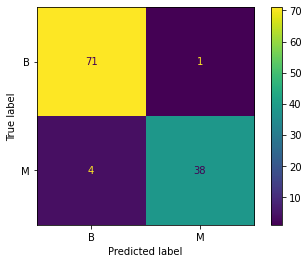

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


# ====================

[[284   1]
 [  9 161]]


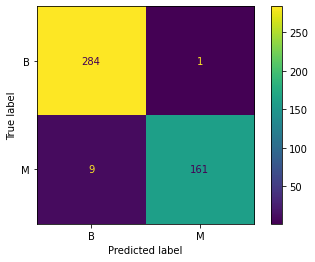

              precision    recall  f1-score   support

           B       0.97      1.00      0.98       285
           M       0.99      0.95      0.97       170

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.98       455
weighted avg       0.98      0.98      0.98       455



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ====================

df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

knn = KNeighborsClassifier().fit(X_train_ss, y_train)

# ====================

y_pred_test = knn.predict(X_test_ss)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

print("\n# ====================\n")

y_pred_train = knn.predict(X_train_ss)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

Entendendo a classificação

In [ ]:
# vamos pegar a primeira observação de teste, como exemplo
X_test_ss[0]

array([-0.24307384, -0.77089916, -2.00602473, -0.76451652, -0.71183971,
       -0.1583148 , -0.68680034, -0.66248612, -0.57475415, -0.53582061,
       -0.22760708, -0.93280815, -1.37244026, -0.85278289, -0.6368401 ,
       -0.2999339 , -0.56993036, -0.53250895, -0.83258923, -0.8416237 ,
       -0.59337276, -0.72135781, -1.63595077, -0.70654903, -0.65337009,
        0.96851866, -0.10446758, -0.30668651, -0.38805702,  0.16254727,
        0.06095804])

In [ ]:
knn.predict(X_test_ss[0].reshape(1, -1))

array(['B'], dtype=object)

In [ ]:
knn.kneighbors(X_test_ss[0].reshape(1, -1))

(array([[1.59659162, 1.91559863, 2.00607687, 2.0694831 , 2.07061232]]),
 array([[236, 164, 428,  98,  34]], dtype=int64))

In [ ]:
X_train.iloc[[236, 164, 428,  98,  34]]

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
271,8910748,11.29,13.04,72.23,388.0,0.09834,0.07608,0.03265,0.02755,0.1769,...,12.32,16.18,78.27,457.5,0.1358,0.1507,0.12750,0.08750,0.2733,0.08022
48,857155,12.05,14.63,78.04,449.3,0.10310,0.09092,0.06592,0.02749,0.1675,...,13.76,20.70,89.88,582.6,0.1494,0.2156,0.30500,0.06548,0.2747,0.08301
527,91813702,12.34,12.27,78.94,468.5,0.09003,0.06307,0.02958,0.02647,0.1689,...,13.61,19.27,87.22,564.9,0.1292,0.2074,0.17910,0.10700,0.3110,0.07592
158,871122,12.06,12.74,76.84,448.6,0.09311,0.05241,0.01972,0.01963,0.1590,...,13.14,18.41,84.08,532.8,0.1275,0.1232,0.08636,0.07025,0.2514,0.07898
390,90317302,10.26,12.22,65.75,321.6,0.09996,0.07542,0.01923,0.01968,0.1800,...,11.38,15.65,73.23,394.5,0.1343,0.1650,0.08615,0.06696,0.2937,0.07722


In [ ]:
y_train.iloc[[236, 164, 428,  98,  34]]

271    B
48     B
527    B
158    B
390    B
Name: diagnosis, dtype: object

__________

Vamos fazer também a validação cruzada!

Mas uma importante alteração é necessária... Se fizermos como antes, usando o target original diretamente:

```python
from sklearn.model_selection import KFold, cross_validate

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = "f1"

results = cross_validate(estimator=estimador,
                         X=X_train, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)
```
Teremos um erro (teste!)

In [ ]:
from sklearn.model_selection import KFold, cross_validate

In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

estimador = KNeighborsClassifier()

# ====================

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = "f1"

results = cross_validate(estimator=estimador,
                         X=X_train, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

C:\Users\andre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\andre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1261, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  

C:\Users\andre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\andre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1123, in f1_score
    return fbeta_score(
  File "C:\Users\andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1261, in fbeta_score
    _, _, f, _ = precision_recall_fscore_support(
  

Não há problema algum em utilizar as classes originais quando deseja-se avaliar o modelo final com a matriz de confusão ou o classification_report. Internamente, é feita um mapeamento pra 0 e 1.

Mas, pra usar o cross_validate, este mapa não é feito. Daí, é necessário que seja explicitamente indicada este mapeamento. Pra fazer isso, há duas opções:

- 1 - Fazer o mapeamento explicitamente e depois usar o código extamente como acima;
- 2 - Indicar qual é a classe positiva (valor 1) na hora de indicar a métrica a ser calculada -- mas pra isso, a função respectiva da métrica deve ser usada, junto com o argumento `pos_label`

Vejamos ambas as opções:

In [ ]:
y.map({"M":1, "B":0})

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# ====================
# alterando o target

y_num = y.map({"M":1, "B":0})

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y_num, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

estimador = KNeighborsClassifier()

# ====================

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = "f1"

results = cross_validate(estimator=estimador,
                         X=X_train_ss, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

pd.DataFrame(results)

,fit_time,score_time,test_score,train_score
0,0.001002,0.003994,0.947368,0.968153
1,0.001000,0.004995,0.977778,0.972222
2,0.000999,0.006999,0.950000,0.969283
3,0.000997,0.003995,1.000000,0.962712
4,0.001000,0.003996,0.952381,0.971061
5,0.000000,0.021948,0.947368,0.965753
6,0.000000,0.016916,0.947368,0.969283
7,0.000000,0.000000,0.937500,0.966443
8,0.000000,0.000000,0.818182,0.970874
9,0.000000,0.015905,0.972973,0.962457


Segunda forma, só indicando o que é a classe positiva:

In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

estimador = KNeighborsClassifier()

# ====================

grupo = KFold(n_splits=10, shuffle=True, random_state=42)


from sklearn.metrics import make_scorer, f1_score

metrica = make_scorer(f1_score, pos_label="M")

results = cross_validate(estimator=estimador,
                         X=X_train_ss, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

pd.DataFrame(results)

,fit_time,score_time,test_score,train_score
0,0.000000,0.000000,0.947368,0.968153
1,0.000000,0.021788,0.977778,0.972222
2,0.002000,0.005996,0.950000,0.969283
3,0.002999,0.004001,1.000000,0.962712
4,0.000998,0.004998,0.952381,0.971061
5,0.002003,0.005993,0.947368,0.965753
6,0.000000,0.018923,0.947368,0.969283
7,0.000000,0.000000,0.937500,0.966443
8,0.000000,0.000000,0.818182,0.970874
9,0.001000,0.003070,0.972973,0.962457


Discutimos que o recall da classe "M" é o que queremos otimizar. Então, vamos, antes de tudo, fazer a CV pra essa métrica:

In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

ss = StandardScaler().fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# ====================

estimador = KNeighborsClassifier()

# ====================

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

from sklearn.metrics import make_scorer, recall_score

metrica = make_scorer(recall_score, pos_label="M")

results = cross_validate(estimator=estimador,
                         X=X_train_ss, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

df_results = pd.DataFrame(results)

In [ ]:
df_results

,fit_time,score_time,test_score,train_score
0,0.001000,0.007451,0.900000,0.950000
1,0.000000,0.000000,0.956522,0.952381
2,0.000000,0.000000,0.950000,0.946667
3,0.002002,0.003994,1.000000,0.934211
4,0.001062,0.000000,0.909091,0.949686
5,0.000000,0.003997,0.900000,0.940000
6,0.000981,0.004016,0.900000,0.946667
7,0.000000,0.000000,0.882353,0.941176
8,0.000000,0.000000,0.750000,0.949367
9,0.000000,0.003997,0.947368,0.933775


In [ ]:
df_results.describe()

,fit_time,score_time,test_score,train_score
count,10.000000,10.000000,10.000000,10.000000
mean,0.000504,0.002345,0.909533,0.944393
std,0.000711,0.002678,0.066603,0.006703
min,0.000000,0.000000,0.750000,0.933775
25%,0.000000,0.000000,0.900000,0.940294
50%,0.000000,0.001997,0.904545,0.946667
75%,0.000995,0.003997,0.949342,0.949606
max,0.002002,0.007451,1.000000,0.952381


O modelo não teve uma performance muito ruim, mas podemos melhorar! Afinal, um modelo de tamanha importância não pode ter uma margem de erro muito grande, não é mesmo?

Vamos iniciar o ciclo de melhorias para ver se conseguimos melhorar a performance do modelo, em um processo que é muitas vezes chamado de **tunning**


**Novamente:** treine os scalers **apenas nos dados de treino** para evitar que informação dos dados de teste sejam passadas para o scaler! (Mais informações [aqui](https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data))

Observe como a performance do modelo mudou!

Mas será que é possível melhorar ainda mais? Vamos agora aprender como é possível testar diferentes parâmetros de uma única vez!

____
____
____

## 2) Ferramentas especiais

Vamos agora ver algumas ferramentas especiais do sklearn que nos ajudam no desenvolvimento de modelos!

### Pipeline

O [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) é uma estrutura que o sklearn proporciona a fim de garantir que possamos em uma única estrutura passar **o estimador e o transformador** (e muitas outras coisas). Para maiores informações, [clique aqui](https://scikit-learn.org/stable/modules/compose.html#pipeline). 

Vamos ver a seguir como esta estrutura funciona:

In [ ]:
from sklearn.pipeline import Pipeline

**Para o train-test split normal**

[[71  1]
 [ 4 38]]


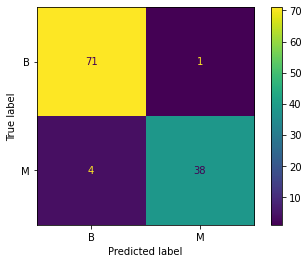

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


# ====================

[[284   1]
 [  9 161]]


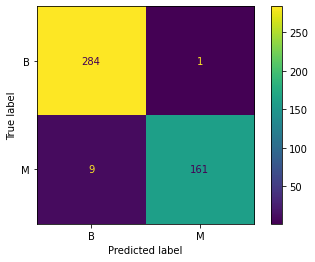

              precision    recall  f1-score   support

           B       0.97      1.00      0.98       285
           M       0.99      0.95      0.97       170

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.98       455
weighted avg       0.98      0.98      0.98       455



In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

# argumento: um lista de tuplas do tipo [("nome da estrutura", classe instanciada da estrutura)]
# na sequencia em que as estruturas (procedimentos) são aplicadas
lista_etapas = [("std_scaler", StandardScaler()), 
                ("knn", KNeighborsClassifier(n_neighbors=5))]

pipe = Pipeline(lista_etapas).fit(X_train, y_train)

# ====================

y_pred_test = pipe.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

print("\n# ====================\n")

y_pred_train = pipe.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

**Para a validação cruzada**

Isso resolve o problema que tivemos na última aula de vazamento de dados na validação cruzada!

In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

lista_etapas = [("std_scaler", StandardScaler()), 
                ("knn", KNeighborsClassifier(n_neighbors=5))]

pipe = Pipeline(lista_etapas)

# ====================

grupo = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = make_scorer(recall_score, pos_label="M")

results = cross_validate(estimator=pipe,
                         X=X_train, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

df_results = pd.DataFrame(results)

In [ ]:
df_results

,fit_time,score_time,test_score,train_score
0,0.000000,0.017809,0.900000,0.950000
1,0.018871,0.006016,0.956522,0.945578
2,0.004995,0.005996,0.950000,0.946667
3,0.007997,0.004081,1.000000,0.934211
4,0.002025,0.000000,0.909091,0.949686
5,0.001056,0.000000,0.900000,0.940000
6,0.000000,0.015630,0.900000,0.946667
7,0.005992,0.005998,0.882353,0.941176
8,0.005996,0.002051,0.750000,0.949367
9,0.002048,0.000000,0.947368,0.933775


In [ ]:
# com isso, resolvemos os problemas que tínhamos anteriormente de vazamento 
# de dados no crossvalidation! essa distribuição é bem mais confiável!!
df_results.describe()

,fit_time,score_time,test_score,train_score
count,10.000000,10.000000,10.000000,10.000000
mean,0.004898,0.005758,0.909533,0.943713
std,0.005641,0.006315,0.066603,0.006123
min,0.000000,0.000000,0.750000,0.933775
25%,0.001298,0.000513,0.900000,0.940294
50%,0.003522,0.005039,0.904545,0.946122
75%,0.005995,0.006011,0.949342,0.948692
max,0.018871,0.017809,1.000000,0.950000


Uma boa ideia é usar o [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html), pois ele mantém a estratificação do target dentro de cada split!

Isso é sobretudo importante pra dados desbalanceados (no target)

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

lista_etapas = [("std_scaler", StandardScaler()), 
                ("knn", KNeighborsClassifier(n_neighbors=5))]

pipe = Pipeline(lista_etapas)

# ====================

# agora, tá estratificado!
grupo = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrica = make_scorer(recall_score, pos_label="M")

results = cross_validate(estimator=pipe,
                         X=X_train, y=y_train,
                         cv=grupo,
                         scoring=metrica,
                         return_train_score=True)

df_results = pd.DataFrame(results)

In [ ]:
df_results.describe()

,fit_time,score_time,test_score,train_score
count,10.000000,10.000000,10.000000,10.000000
mean,0.009994,0.009293,0.911765,0.945098
std,0.006051,0.003162,0.100938,0.008267
min,0.003996,0.005994,0.705882,0.934641
25%,0.006248,0.006497,0.838235,0.941176
50%,0.008997,0.008991,0.941176,0.944444
75%,0.011739,0.010739,1.000000,0.947712
max,0.024985,0.015992,1.000000,0.960784


______

### Gridsearch

O [Gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) é uma estrutura que o sklearn proporciona para que seja feita **a busca exaustiva de hiperparâmetros de um estimador**.

Na prática, o que o gridsearch faz é **treinar diversos modelos com diferentes combinações de hiperparâmetros**, de modo a manter o melhor deles como o modelo final, tudo automaticamente! 

Tudo o que precisamos fazer é indicar quais os hiperparâmetros que queremos procurar: a **grade**!

<img src="https://www.yourdatateacher.com/wp-content/uploads/2021/03/image-6.png" width=500>

É muito comum também passarmos o **Pipeline** como argumento do gridsearch!

Para maiores informações, [clique aqui](https://scikit-learn.org/stable/modules/grid_search.html#grid-search). 

Vamos ver a seguir como esta estrutura funciona:

O Gridsearch avalia o melhor modelo segundo a métrica que passamos em `scoring`. [Clique aqui](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) para ver as métricas disponíveis por padrão.

Mas o GS vai além: ele não calcula a métrica uma única vez, mas sim **várias vezes**, conforme especificado pelo parâmetro `cv`. No fim, o melhor modelo é o que tem o melhor scoring **médio** entre as vezes que é calculado.

O "cv" quer dizer **Cross Validation**, o método mais seguro de realizar um treinamento e avaliação de um modelo que conhecemos na aula passada!

<img src="https://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png" width=600> 

Com a validação cruzada, garantimos uma avaliação justa de cada um dos modelos candidatos (cada um construído com uma combinação diferente de hiperparâmetros).

Assim, sabemos que a melhor combinação de hiperparâmetros a ser encontrada não estará de qualquer forma "overfitada" em particularidades da base de treino!

Vamos colocar tudo em uma única célula:

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

lista_etapas = [("std_scaler", StandardScaler()), 
                ("knn", KNeighborsClassifier())]

pipe = Pipeline(lista_etapas)

# ====================

# agora, tá estratificado!
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrica = make_scorer(recall_score, pos_label="M")

# ====================

param_grid = {"knn__weights" : ["uniform", "distance"],
              "knn__metric" : ["manhattan", "euclidean"],
              "knn__n_neighbors" : range(2, 21)}

# verbose=10 pra muitas combinações, os prints vão pro terminal
grid_knn = GridSearchCV(estimator=pipe, 
                        param_grid=param_grid,
                        scoring=metrica,
                        cv=splitter,
                        verbose=10)

grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 76 candidates, totalling 760 fits
[CV 1/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 1/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=0.941 total time=   0.0s
[CV 2/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 2/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 3/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 3/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=0.941 total time=   0.0s
[CV 4/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 4/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 5/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 5/10; 1/76] END knn__metric=manhatt

[CV 4/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 5/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 5/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 6/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 6/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 7/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 7/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=0.765 total time=   0.0s
[CV 8/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 8/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 9/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__w

[CV 9/10; 9/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 10/10; 9/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform
[CV 10/10; 9/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 1/10; 10/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=distance
[CV 1/10; 10/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 2/10; 10/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=distance
[CV 2/10; 10/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=distance;, score=0.882 total time=   0.0s
[CV 3/10; 10/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=distance
[CV 3/10; 10/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 4/10; 10/76] START knn__metric=manhattan, knn__n_neig

[CV 2/10; 14/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance;, score=0.824 total time=   0.0s
[CV 3/10; 14/76] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance
[CV 3/10; 14/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 4/10; 14/76] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance
[CV 4/10; 14/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 5/10; 14/76] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance
[CV 5/10; 14/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance;, score=0.882 total time=   0.0s
[CV 6/10; 14/76] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance
[CV 6/10; 14/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance;, score=0.824 total time=   0.0s
[CV 7/10; 14/76] START knn__metric=manhattan, knn__n_

[CV 10/10; 18/76] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 1/10; 19/76] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform
[CV 1/10; 19/76] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 2/10; 19/76] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform
[CV 2/10; 19/76] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 3/10; 19/76] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform
[CV 3/10; 19/76] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 4/10; 19/76] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform
[CV 4/10; 19/76] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 5/10; 19/76] START knn__metric=manhattan, knn__

[CV 2/10; 23/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 3/10; 23/76] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform
[CV 3/10; 23/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 4/10; 23/76] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform
[CV 4/10; 23/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 5/10; 23/76] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform
[CV 5/10; 23/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 6/10; 23/76] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform
[CV 6/10; 23/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 7/10; 23/76] START knn__metric=manhattan, knn__n_

[CV 8/10; 27/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 9/10; 27/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform
[CV 9/10; 27/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 10/10; 27/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform
[CV 10/10; 27/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 1/10; 28/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance
[CV 1/10; 28/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 2/10; 28/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance
[CV 2/10; 28/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance;, score=0.824 total time=   0.0s
[CV 3/10; 28/76] START knn__metric=manhattan, k

[CV 10/10; 31/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 1/10; 32/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance
[CV 1/10; 32/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 2/10; 32/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance
[CV 2/10; 32/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance;, score=0.824 total time=   0.0s
[CV 3/10; 32/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance
[CV 3/10; 32/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 4/10; 32/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance
[CV 4/10; 32/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 5/10; 32/76] START knn__metric=manhattan

[CV 4/10; 36/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 5/10; 36/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance
[CV 5/10; 36/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=0.765 total time=   0.0s
[CV 6/10; 36/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance
[CV 6/10; 36/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=0.824 total time=   0.0s
[CV 7/10; 36/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance
[CV 7/10; 36/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=0.765 total time=   0.0s
[CV 8/10; 36/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance
[CV 8/10; 36/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 9/10; 36/76] START knn__metric=manhattan

[CV 9/10; 40/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 10/10; 40/76] START knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance
[CV 10/10; 40/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance;, score=0.882 total time=   0.0s
[CV 1/10; 41/76] START knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform
[CV 1/10; 41/76] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 2/10; 41/76] START knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform
[CV 2/10; 41/76] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 3/10; 41/76] START knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform
[CV 3/10; 41/76] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 4/10; 41/76] START knn__metric=euclidean, knn__n_neig

[CV 9/10; 44/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 10/10; 44/76] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance
[CV 10/10; 44/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 1/10; 45/76] START knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform
[CV 1/10; 45/76] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 2/10; 45/76] START knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform
[CV 2/10; 45/76] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 3/10; 45/76] START knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform
[CV 3/10; 45/76] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 4/10; 45/76] START knn__metric=euclidean, knn__n_neig

[CV 10/10; 48/76] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 1/10; 49/76] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform
[CV 1/10; 49/76] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 2/10; 49/76] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform
[CV 2/10; 49/76] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 3/10; 49/76] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform
[CV 3/10; 49/76] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 4/10; 49/76] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform
[CV 4/10; 49/76] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 5/10; 49/76] START knn__metric=euclidean, knn__n_neighbo

[CV 5/10; 53/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 6/10; 53/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform
[CV 6/10; 53/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 7/10; 53/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform
[CV 7/10; 53/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform;, score=0.765 total time=   0.0s
[CV 8/10; 53/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform
[CV 8/10; 53/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 9/10; 53/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform
[CV 9/10; 53/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 10/10; 53/76] START knn__metric=euclidean, knn__n_neighbor

[CV 3/10; 58/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 4/10; 58/76] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 4/10; 58/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 5/10; 58/76] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 5/10; 58/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.882 total time=   0.0s
[CV 6/10; 58/76] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 6/10; 58/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.882 total time=   0.0s
[CV 7/10; 58/76] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 7/10; 58/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.765 total time=   0.0s
[CV 8/10; 58/76] START knn__metric=euclidean

[CV 8/10; 62/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 9/10; 62/76] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 9/10; 62/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 10/10; 62/76] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 10/10; 62/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=0.882 total time=   0.0s
[CV 1/10; 63/76] START knn__metric=euclidean, knn__n_neighbors=14, knn__weights=uniform
[CV 1/10; 63/76] END knn__metric=euclidean, knn__n_neighbors=14, knn__weights=uniform;, score=0.941 total time=   0.0s
[CV 2/10; 63/76] START knn__metric=euclidean, knn__n_neighbors=14, knn__weights=uniform
[CV 2/10; 63/76] END knn__metric=euclidean, knn__n_neighbors=14, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 3/10; 63/76] START knn__metric=euclidean, 

[CV 7/10; 66/76] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=0.765 total time=   0.0s
[CV 8/10; 66/76] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance
[CV 8/10; 66/76] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 9/10; 66/76] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance
[CV 9/10; 66/76] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 10/10; 66/76] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance
[CV 10/10; 66/76] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=0.882 total time=   0.0s
[CV 1/10; 67/76] START knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform
[CV 1/10; 67/76] END knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform;, score=0.941 total time=   0.0s
[CV 2/10; 67/76] START knn__metric=euclidean

[CV 3/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 3/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=0.941 total time=   0.0s
[CV 4/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 4/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 5/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 5/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 6/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 6/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 7/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 7/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=unifor

[CV 7/10; 75/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform;, score=0.765 total time=   0.0s
[CV 8/10; 75/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform
[CV 8/10; 75/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 9/10; 75/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform
[CV 9/10; 75/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 10/10; 75/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform
[CV 10/10; 75/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 1/10; 76/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance
[CV 1/10; 76/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 2/10; 76/76] START knn__metric=euclidean, knn

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 21),
                         'knn__weights': ['uniform', 'distance']},
             scoring=make_scorer(recall_score, pos_label=M), verbose=10)

In [ ]:
grid_knn

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 21),
                         'knn__weights': ['uniform', 'distance']},
             scoring=make_scorer(recall_score, pos_label=M), verbose=10)

O GS treinado tem diversos atributos super úteis e interessantes! Vamos dar uma olhada neles:

`.best_estimator_`: retorna quais as escolhas do Pipeline que produziram o melhor modelo. No que diz respeito ao modelo, temos exatamente quais os parâmetros escolhidos!

In [ ]:
grid_knn.best_estimator_

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3))])

`.best_params_`: retorna os parâmetros testados na grade que produziram o melhor modelo.

In [ ]:
grid_knn.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}

`.best_score_`: retorna a **média cross-validada da métrica de interesse** do melhor modelo. Como esse é o valor médio construído usando CV, este é estatisticamente o valor mais realístico a ser atribuído à performance do modelo!

In [ ]:
grid_knn.best_score_

0.9411764705882353

`.cv_results_`: diversas informações do processo feito pelo GS

In [ ]:
grid_knn.cv_results_

{'mean_fit_time': array([0.00949402, 0.00889583, 0.00809772, 0.00979452, 0.00799429,
        0.01209369, 0.01229553, 0.01179366, 0.01019757, 0.00689554,
        0.01139386, 0.0174895 , 0.01239226, 0.00980432, 0.00889609,
        0.00929685, 0.00649631, 0.00659742, 0.00859144, 0.00659626,
        0.00769582, 0.00889504, 0.01169448, 0.01334431, 0.01119423,
        0.01109467, 0.00789523, 0.00754738, 0.00749471, 0.00639505,
        0.00799956, 0.0076973 , 0.00859232, 0.00897286, 0.0082943 ,
        0.00949142, 0.00929358, 0.01159341, 0.00837116, 0.01629038,
        0.00809479, 0.01089287, 0.00769563, 0.01139147, 0.00981672,
        0.00849473, 0.00719278, 0.01009436, 0.01359382, 0.00829628,
        0.01009514, 0.00959291, 0.01178274, 0.01259661, 0.01329219,
        0.00999417, 0.0128937 , 0.00999439, 0.0109868 , 0.01009479,
        0.01004472, 0.00999482, 0.01469178, 0.01129436, 0.01343689,
        0.0254842 , 0.01279364, 0.01104405, 0.0111938 , 0.01058636,
        0.01599033, 0.00799539,

In [ ]:
# dataframe, onde cada linha é uma combinação de hps da grade
df_results = pd.DataFrame(grid_knn.cv_results_).sort_values("rank_test_score")

In [ ]:
df_results.columns.tolist()

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_knn__metric',
 'param_knn__n_neighbors',
 'param_knn__weights',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'split5_test_score',
 'split6_test_score',
 'split7_test_score',
 'split8_test_score',
 'split9_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score']

In [ ]:
df_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
2,0.008098,0.003804,0.011491,0.006958,manhattan,3,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.000000,0.882353,...,1.0,0.941176,0.882353,0.764706,1.000000,1.000000,0.941176,0.941176,0.074407,1
3,0.009795,0.005285,0.006496,0.001564,manhattan,3,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.000000,0.882353,...,1.0,0.941176,0.882353,0.764706,1.000000,1.000000,0.941176,0.941176,0.074407,1
5,0.012094,0.007031,0.008795,0.005171,manhattan,4,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.000000,0.882353,...,1.0,0.941176,0.882353,0.764706,1.000000,1.000000,0.941176,0.941176,0.074407,1
6,0.012296,0.008109,0.011608,0.004877,manhattan,5,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.000000,0.882353,...,1.0,0.941176,0.882353,0.764706,1.000000,1.000000,0.941176,0.941176,0.074407,1
7,0.011794,0.005304,0.009994,0.006996,manhattan,5,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.000000,0.882353,...,1.0,0.941176,0.882353,0.764706,1.000000,1.000000,0.941176,0.941176,0.074407,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,0.008371,0.002183,0.013293,0.005914,euclidean,2,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.941176,0.823529,...,1.0,0.882353,0.823529,0.764706,1.000000,0.882353,0.882353,0.894118,0.073471,71
28,0.007495,0.003322,0.008772,0.005240,manhattan,16,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.941176,0.823529,...,1.0,0.764706,0.823529,0.764706,0.941176,1.000000,0.882353,0.894118,0.090366,71
32,0.008592,0.005141,0.008196,0.001938,manhattan,18,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.941176,0.823529,...,1.0,0.764706,0.823529,0.764706,0.941176,1.000000,0.823529,0.888235,0.092822,74
74,0.013592,0.004519,0.017390,0.008147,euclidean,20,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.941176,0.823529,...,1.0,0.764706,0.823529,0.764706,1.000000,1.000000,0.823529,0.888235,0.092822,74


____________

Agora, com duas métricas:

In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

lista_etapas = [("std_scaler", StandardScaler()), 
                ("knn", KNeighborsClassifier())]

pipe = Pipeline(lista_etapas)

# ====================

# agora, tá estratificado!
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrica1 = make_scorer(recall_score, pos_label="M")
metrica2 = make_scorer(f1_score, pos_label="M")

# ====================

param_grid = {"knn__weights" : ["uniform", "distance"],
              "knn__metric" : ["manhattan", "euclidean"],
              "knn__n_neighbors" : range(2, 21)}

# verbose=10 pra muitas combinações, os prints vão pro terminal
grid_knn = GridSearchCV(estimator=pipe, 
                        param_grid=param_grid,
                        scoring={"recall": metrica1, "f1" : metrica2},
                        cv=splitter,
                        verbose=20,
                        refit="f1")

grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 76 candidates, totalling 760 fits
[CV 1/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 1/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform; f1: (test=0.970) recall: (test=0.941) total time=   0.0s
[CV 2/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 2/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 3/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 3/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform; f1: (test=0.970) recall: (test=0.941) total time=   0.0s
[CV 4/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 4/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 5/10; 1/76] START knn

[CV 9/10; 4/76] END knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 10/10; 4/76] START knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance
[CV 10/10; 4/76] END knn__metric=manhattan, knn__n_neighbors=3, knn__weights=distance; f1: (test=0.970) recall: (test=0.941) total time=   0.0s
[CV 1/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 1/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 2/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 3/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 3/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform

[CV 5/10; 8/76] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance; f1: (test=0.970) recall: (test=0.941) total time=   0.0s
[CV 6/10; 8/76] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 6/10; 8/76] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 7/10; 8/76] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 7/10; 8/76] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance; f1: (test=0.839) recall: (test=0.765) total time=   0.0s
[CV 8/10; 8/76] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 8/10; 8/76] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 9/10; 8/76] START knn__metric=manhattan, knn__n_neighbors=5, knn__weights=distance
[CV 9/10; 8/76] END knn__metric=manhattan, knn__n_neighbors=5, knn__weights=dist

[CV 2/10; 12/76] END knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance; f1: (test=0.903) recall: (test=0.824) total time=   0.0s
[CV 3/10; 12/76] START knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance
[CV 3/10; 12/76] END knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/10; 12/76] START knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance
[CV 4/10; 12/76] END knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance; f1: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 5/10; 12/76] START knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance
[CV 5/10; 12/76] END knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 6/10; 12/76] START knn__metric=manhattan, knn__n_neighbors=7, knn__weights=distance
[CV 6/10; 12/76] END knn__metric=manhattan, knn__n_neighbors=7, knn__wei

[CV 7/10; 15/76] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=uniform; f1: (test=0.839) recall: (test=0.765) total time=   0.0s
[CV 8/10; 15/76] START knn__metric=manhattan, knn__n_neighbors=9, knn__weights=uniform
[CV 8/10; 15/76] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=uniform; f1: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 9/10; 15/76] START knn__metric=manhattan, knn__n_neighbors=9, knn__weights=uniform
[CV 9/10; 15/76] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=uniform; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 10/10; 15/76] START knn__metric=manhattan, knn__n_neighbors=9, knn__weights=uniform
[CV 10/10; 15/76] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=uniform; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 1/10; 16/76] START knn__metric=manhattan, knn__n_neighbors=9, knn__weights=distance
[CV 1/10; 16/76] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=

[CV 9/10; 19/76] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 10/10; 19/76] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform
[CV 10/10; 19/76] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 1/10; 20/76] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance
[CV 1/10; 20/76] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/10; 20/76] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance
[CV 2/10; 20/76] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance; f1: (test=0.903) recall: (test=0.824) total time=   0.0s
[CV 3/10; 20/76] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=distance
[CV 3/10; 20/76] END knn__metric=manhattan, knn__n_neighbors=11, 

[CV 4/10; 23/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 5/10; 23/76] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform
[CV 5/10; 23/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform; f1: (test=0.903) recall: (test=0.824) total time=   0.0s
[CV 6/10; 23/76] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform
[CV 6/10; 23/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform; f1: (test=0.903) recall: (test=0.824) total time=   0.0s
[CV 7/10; 23/76] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform
[CV 7/10; 23/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform; f1: (test=0.839) recall: (test=0.765) total time=   0.0s
[CV 8/10; 23/76] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform
[CV 8/10; 23/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__we

[CV 1/10; 27/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform; f1: (test=0.970) recall: (test=0.941) total time=   0.0s
[CV 2/10; 27/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform
[CV 2/10; 27/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform; f1: (test=0.903) recall: (test=0.824) total time=   0.0s
[CV 3/10; 27/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform
[CV 3/10; 27/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform; f1: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 4/10; 27/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform
[CV 4/10; 27/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 5/10; 27/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform
[CV 5/10; 27/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__we

[CV 9/10; 30/76] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 10/10; 30/76] START knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance
[CV 10/10; 30/76] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 1/10; 31/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform
[CV 1/10; 31/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform; f1: (test=0.970) recall: (test=0.941) total time=   0.0s
[CV 2/10; 31/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform
[CV 2/10; 31/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform; f1: (test=0.903) recall: (test=0.824) total time=   0.0s
[CV 3/10; 31/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform
[CV 3/10; 31/76] END knn__metric=manhattan, knn__n_neighbors=17, kn

[CV 10/10; 34/76] END knn__metric=manhattan, knn__n_neighbors=18, knn__weights=distance; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 1/10; 35/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform
[CV 1/10; 35/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform; f1: (test=0.970) recall: (test=0.941) total time=   0.0s
[CV 2/10; 35/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform
[CV 2/10; 35/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform; f1: (test=0.903) recall: (test=0.824) total time=   0.0s
[CV 3/10; 35/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform
[CV 3/10; 35/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform; f1: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 4/10; 35/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform
[CV 4/10; 35/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__

[CV 2/10; 39/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=uniform; f1: (test=0.903) recall: (test=0.824) total time=   0.0s
[CV 3/10; 39/76] START knn__metric=euclidean, knn__n_neighbors=2, knn__weights=uniform
[CV 3/10; 39/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=uniform; f1: (test=0.970) recall: (test=0.941) total time=   0.0s
[CV 4/10; 39/76] START knn__metric=euclidean, knn__n_neighbors=2, knn__weights=uniform
[CV 4/10; 39/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=uniform; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 5/10; 39/76] START knn__metric=euclidean, knn__n_neighbors=2, knn__weights=uniform
[CV 5/10; 39/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=uniform; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 6/10; 39/76] START knn__metric=euclidean, knn__n_neighbors=2, knn__weights=uniform
[CV 6/10; 39/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=uni

[CV 2/10; 43/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform; f1: (test=0.867) recall: (test=0.765) total time=   0.0s
[CV 3/10; 43/76] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 3/10; 43/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/10; 43/76] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 4/10; 43/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 5/10; 43/76] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 5/10; 43/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 6/10; 43/76] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uniform
[CV 6/10; 43/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=uni

[CV 2/10; 47/76] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform
[CV 2/10; 47/76] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform; f1: (test=0.903) recall: (test=0.824) total time=   0.0s
[CV 3/10; 47/76] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform
[CV 3/10; 47/76] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 4/10; 47/76] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform
[CV 4/10; 47/76] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 5/10; 47/76] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform
[CV 5/10; 47/76] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 6/10; 47/76] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=u

[CV 8/10; 50/76] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 9/10; 50/76] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance
[CV 9/10; 50/76] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 10/10; 50/76] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance
[CV 10/10; 50/76] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=distance; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 1/10; 51/76] START knn__metric=euclidean, knn__n_neighbors=8, knn__weights=uniform
[CV 1/10; 51/76] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=uniform; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 2/10; 51/76] START knn__metric=euclidean, knn__n_neighbors=8, knn__weights=uniform
[CV 2/10; 51/76] END knn__metric=euclidean, knn__n_neighbors=8, knn__weig

[CV 4/10; 54/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 5/10; 54/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance
[CV 5/10; 54/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 6/10; 54/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance
[CV 6/10; 54/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 7/10; 54/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance
[CV 7/10; 54/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance; f1: (test=0.839) recall: (test=0.765) total time=   0.0s
[CV 8/10; 54/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=distance
[CV 8/10; 54/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__wei

[CV 7/10; 58/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance; f1: (test=0.839) recall: (test=0.765) total time=   0.0s
[CV 8/10; 58/76] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 8/10; 58/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance; f1: (test=0.971) recall: (test=1.000) total time=   0.0s
[CV 9/10; 58/76] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 9/10; 58/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 10/10; 58/76] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 10/10; 58/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 1/10; 59/76] START knn__metric=euclidean, knn__n_neighbors=12, knn__weights=uniform
[CV 1/10; 59/76] END knn__metric=euclidean, knn__n_neighbors=12

[CV 6/10; 62/76] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 6/10; 62/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance; f1: (test=0.903) recall: (test=0.824) total time=   0.0s
[CV 7/10; 62/76] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 7/10; 62/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance; f1: (test=0.839) recall: (test=0.765) total time=   0.0s
[CV 8/10; 62/76] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 8/10; 62/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 9/10; 62/76] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 9/10; 62/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 10/10; 62/76] START knn__metric=euclidean, knn__n_neighbors=

[CV 10/10; 66/76] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 1/10; 67/76] START knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform
[CV 1/10; 67/76] END knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform; f1: (test=0.970) recall: (test=0.941) total time=   0.0s
[CV 2/10; 67/76] START knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform
[CV 2/10; 67/76] END knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform; f1: (test=0.903) recall: (test=0.824) total time=   0.0s
[CV 3/10; 67/76] START knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform
[CV 3/10; 67/76] END knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform; f1: (test=0.970) recall: (test=0.941) total time=   0.0s
[CV 4/10; 67/76] START knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform
[CV 4/10; 67/76] END knn__metric=euclidean, knn__n_neighbors=16, knn__

[CV 2/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform; f1: (test=0.903) recall: (test=0.824) total time=   0.0s
[CV 3/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 3/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform; f1: (test=0.970) recall: (test=0.941) total time=   0.0s
[CV 4/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 4/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 5/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 5/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform; f1: (test=0.903) recall: (test=0.824) total time=   0.0s
[CV 6/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 6/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__we

[CV 8/10; 74/76] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 9/10; 74/76] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance
[CV 9/10; 74/76] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance; f1: (test=1.000) recall: (test=1.000) total time=   0.0s
[CV 10/10; 74/76] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance
[CV 10/10; 74/76] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance; f1: (test=0.938) recall: (test=0.882) total time=   0.0s
[CV 1/10; 75/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform
[CV 1/10; 75/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform; f1: (test=0.970) recall: (test=0.941) total time=   0.0s
[CV 2/10; 75/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform
[CV 2/10; 75/76] END knn__metric=euclidean, knn__n_neighbors=20, 

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 21),
                         'knn__weights': ['uniform', 'distance']},
             refit='f1',
             scoring={'f1': make_scorer(f1_score, pos_label=M),
                      'recall': make_scorer(recall_score, pos_label=M)},
             verbose=20)

In [ ]:
df_results_multi_metric = pd.DataFrame(grid_knn.cv_results_)

In [ ]:
df_results_multi_metric.columns.tolist()

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_knn__metric',
 'param_knn__n_neighbors',
 'param_knn__weights',
 'params',
 'split0_test_recall',
 'split1_test_recall',
 'split2_test_recall',
 'split3_test_recall',
 'split4_test_recall',
 'split5_test_recall',
 'split6_test_recall',
 'split7_test_recall',
 'split8_test_recall',
 'split9_test_recall',
 'mean_test_recall',
 'std_test_recall',
 'rank_test_recall',
 'split0_test_f1',
 'split1_test_f1',
 'split2_test_f1',
 'split3_test_f1',
 'split4_test_f1',
 'split5_test_f1',
 'split6_test_f1',
 'split7_test_f1',
 'split8_test_f1',
 'split9_test_f1',
 'mean_test_f1',
 'std_test_f1',
 'rank_test_f1']

In [ ]:
df_results_multi_metric.sort_values(['rank_test_recall', 'rank_test_f1'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,params,split0_test_recall,split1_test_recall,...,split3_test_f1,split4_test_f1,split5_test_f1,split6_test_f1,split7_test_f1,split8_test_f1,split9_test_f1,mean_test_f1,std_test_f1,rank_test_f1
6,0.011892,0.002165,0.028088,0.010514,manhattan,5,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.000000,0.882353,...,1.0,0.969697,0.937500,0.83871,1.000000,1.000000,0.969697,0.965310,0.048611,1
7,0.012394,0.006737,0.019189,0.014384,manhattan,5,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.000000,0.882353,...,1.0,0.969697,0.937500,0.83871,1.000000,1.000000,0.969697,0.965310,0.048611,1
9,0.017390,0.011414,0.015992,0.012868,manhattan,6,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.000000,0.882353,...,1.0,0.969697,0.937500,0.83871,1.000000,1.000000,0.969697,0.965310,0.048611,1
2,0.014893,0.007939,0.014092,0.005482,manhattan,3,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.000000,0.882353,...,1.0,0.969697,0.937500,0.83871,0.971429,1.000000,0.969697,0.959596,0.045795,5
3,0.012993,0.006353,0.015292,0.005863,manhattan,3,distance,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",1.000000,0.882353,...,1.0,0.969697,0.937500,0.83871,0.971429,1.000000,0.969697,0.959596,0.045795,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,0.010594,0.003876,0.011692,0.003098,manhattan,16,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.941176,0.823529,...,1.0,0.866667,0.903226,0.83871,0.969697,1.000000,0.937500,0.936015,0.053048,71
20,0.007898,0.002384,0.009196,0.002185,manhattan,12,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.941176,0.823529,...,1.0,0.866667,0.903226,0.83871,0.971429,1.000000,0.903226,0.935618,0.056721,72
74,0.012292,0.005077,0.014193,0.005992,euclidean,20,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.941176,0.823529,...,1.0,0.866667,0.903226,0.83871,1.000000,1.000000,0.903226,0.935445,0.056613,73
32,0.016890,0.006135,0.029784,0.012337,manhattan,18,uniform,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",0.941176,0.823529,...,1.0,0.866667,0.903226,0.83871,0.969697,1.000000,0.903226,0.932588,0.053941,75


Podemos mudar a métrica segundo a qual otimizaremos os hiperparâmetros!

In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

lista_etapas = [("std_scaler", StandardScaler()), 
                ("knn", KNeighborsClassifier())]

pipe = Pipeline(lista_etapas)

# ====================

# agora, tá estratificado!
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrica = make_scorer(f1_score, pos_label="M")

# ====================

param_grid = {"knn__weights" : ["uniform", "distance"],
              "knn__metric" : ["manhattan", "euclidean"],
              "knn__n_neighbors" : range(2, 21)}

# verbose=10 pra muitas combinações, os prints vão pro terminal
grid_knn = GridSearchCV(estimator=pipe, 
                        param_grid=param_grid,
                        scoring=metrica,
                        cv=splitter,
                        verbose=10)

grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 76 candidates, totalling 760 fits
[CV 1/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 1/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=0.970 total time=   0.0s
[CV 2/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 2/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=0.938 total time=   0.0s
[CV 3/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 3/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=0.970 total time=   0.0s
[CV 4/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 4/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 5/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 5/10; 1/76] END knn__metric=manhatt

[CV 2/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=0.938 total time=   0.0s
[CV 3/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 3/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 4/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 4/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 5/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 5/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=0.938 total time=   0.0s
[CV 6/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 6/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=0.903 total time=   0.0s
[CV 7/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__w

[CV 9/10; 9/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 10/10; 9/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform
[CV 10/10; 9/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=0.938 total time=   0.0s
[CV 1/10; 10/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=distance
[CV 1/10; 10/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 2/10; 10/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=distance
[CV 2/10; 10/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=distance;, score=0.938 total time=   0.0s
[CV 3/10; 10/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=distance
[CV 3/10; 10/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 4/10; 10/76] START knn__metric=manhattan, knn__n_neig

[CV 8/10; 14/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 9/10; 14/76] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance
[CV 9/10; 14/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 10/10; 14/76] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance
[CV 10/10; 14/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance;, score=0.970 total time=   0.0s
[CV 1/10; 15/76] START knn__metric=manhattan, knn__n_neighbors=9, knn__weights=uniform
[CV 1/10; 15/76] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=uniform;, score=0.970 total time=   0.0s
[CV 2/10; 15/76] START knn__metric=manhattan, knn__n_neighbors=9, knn__weights=uniform
[CV 2/10; 15/76] END knn__metric=manhattan, knn__n_neighbors=9, knn__weights=uniform;, score=0.903 total time=   0.0s
[CV 3/10; 15/76] START knn__metric=manhattan, knn__n_ne

[CV 4/10; 19/76] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 5/10; 19/76] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform
[CV 5/10; 19/76] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform;, score=0.938 total time=   0.0s
[CV 6/10; 19/76] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform
[CV 6/10; 19/76] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform;, score=0.903 total time=   0.0s
[CV 7/10; 19/76] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform
[CV 7/10; 19/76] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform;, score=0.839 total time=   0.0s
[CV 8/10; 19/76] START knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform
[CV 8/10; 19/76] END knn__metric=manhattan, knn__n_neighbors=11, knn__weights=uniform;, score=0.971 total time=   0.0s
[CV 9/10; 19/76] START knn__metric=manhattan, knn__n_

[CV 1/10; 24/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance;, score=0.970 total time=   0.0s
[CV 2/10; 24/76] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance
[CV 2/10; 24/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance;, score=0.903 total time=   0.0s
[CV 3/10; 24/76] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance
[CV 3/10; 24/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 4/10; 24/76] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance
[CV 4/10; 24/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 5/10; 24/76] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance
[CV 5/10; 24/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=distance;, score=0.938 total time=   0.0s
[CV 6/10; 24/76] START knn__metric=manhattan

[CV 4/10; 28/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance
[CV 4/10; 28/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 5/10; 28/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance
[CV 5/10; 28/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance;, score=0.903 total time=   0.0s
[CV 6/10; 28/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance
[CV 6/10; 28/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance;, score=0.903 total time=   0.0s
[CV 7/10; 28/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance
[CV 7/10; 28/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance;, score=0.839 total time=   0.0s
[CV 8/10; 28/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=distance
[CV 8/10; 28/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weigh

[CV 4/10; 32/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance
[CV 4/10; 32/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 5/10; 32/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance
[CV 5/10; 32/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance;, score=0.867 total time=   0.0s
[CV 6/10; 32/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance
[CV 6/10; 32/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance;, score=0.903 total time=   0.0s
[CV 7/10; 32/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance
[CV 7/10; 32/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance;, score=0.839 total time=   0.0s
[CV 8/10; 32/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance
[CV 8/10; 32/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weigh

[CV 5/10; 36/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=0.867 total time=   0.0s
[CV 6/10; 36/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance
[CV 6/10; 36/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=0.903 total time=   0.0s
[CV 7/10; 36/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance
[CV 7/10; 36/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=0.839 total time=   0.0s
[CV 8/10; 36/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance
[CV 8/10; 36/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 9/10; 36/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance
[CV 9/10; 36/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 10/10; 36/76] START knn__metric=manhatta

[CV 4/10; 40/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 5/10; 40/76] START knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance
[CV 5/10; 40/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance;, score=0.970 total time=   0.0s
[CV 6/10; 40/76] START knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance
[CV 6/10; 40/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance;, score=0.848 total time=   0.0s
[CV 7/10; 40/76] START knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance
[CV 7/10; 40/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance;, score=0.875 total time=   0.0s
[CV 8/10; 40/76] START knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance
[CV 8/10; 40/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 9/10; 40/76] START knn__metric=euclidean, knn__n_

[CV 6/10; 44/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance;, score=0.938 total time=   0.0s
[CV 7/10; 44/76] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance
[CV 7/10; 44/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance;, score=0.839 total time=   0.0s
[CV 8/10; 44/76] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance
[CV 8/10; 44/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 9/10; 44/76] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance
[CV 9/10; 44/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance;, score=0.970 total time=   0.0s
[CV 10/10; 44/76] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance
[CV 10/10; 44/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance;, score=0.970 total time=   0.0s
[CV 1/10; 45/76] START knn__metric=euclidean, knn__

[CV 9/10; 48/76] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=distance;, score=0.970 total time=   0.0s
[CV 10/10; 48/76] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=distance
[CV 10/10; 48/76] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=distance;, score=0.970 total time=   0.0s
[CV 1/10; 49/76] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform
[CV 1/10; 49/76] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 2/10; 49/76] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform
[CV 2/10; 49/76] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform;, score=0.903 total time=   0.0s
[CV 3/10; 49/76] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform
[CV 3/10; 49/76] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 4/10; 49/76] START knn__metric=euclidean, knn__n_neig

[CV 1/10; 53/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 2/10; 53/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform
[CV 2/10; 53/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform;, score=0.903 total time=   0.0s
[CV 3/10; 53/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform
[CV 3/10; 53/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform;, score=0.941 total time=   0.0s
[CV 4/10; 53/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform
[CV 4/10; 53/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 5/10; 53/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform
[CV 5/10; 53/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform;, score=0.938 total time=   0.0s
[CV 6/10; 53/76] START knn__metric=euclidean, knn__n_neighbors

[CV 6/10; 57/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform;, score=0.938 total time=   0.0s
[CV 7/10; 57/76] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform
[CV 7/10; 57/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform;, score=0.839 total time=   0.0s
[CV 8/10; 57/76] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform
[CV 8/10; 57/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform;, score=0.971 total time=   0.0s
[CV 9/10; 57/76] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform
[CV 9/10; 57/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 10/10; 57/76] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform
[CV 10/10; 57/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform;, score=0.938 total time=   0.0s
[CV 1/10; 58/76] START knn__metric=euclidean, knn__

[CV 8/10; 61/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 9/10; 61/76] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform
[CV 9/10; 61/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 10/10; 61/76] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform
[CV 10/10; 61/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=uniform;, score=0.938 total time=   0.0s
[CV 1/10; 62/76] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 1/10; 62/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=0.970 total time=   0.0s
[CV 2/10; 62/76] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 2/10; 62/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=0.903 total time=   0.0s
[CV 3/10; 62/76] START knn__metric=euclidean, k

[CV 10/10; 65/76] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=uniform;, score=0.938 total time=   0.0s
[CV 1/10; 66/76] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance
[CV 1/10; 66/76] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=0.970 total time=   0.0s
[CV 2/10; 66/76] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance
[CV 2/10; 66/76] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=0.903 total time=   0.0s
[CV 3/10; 66/76] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance
[CV 3/10; 66/76] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=0.970 total time=   0.0s
[CV 4/10; 66/76] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance
[CV 4/10; 66/76] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 5/10; 66/76] START knn__metric=euclidean

[CV 4/10; 70/76] END knn__metric=euclidean, knn__n_neighbors=17, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 5/10; 70/76] START knn__metric=euclidean, knn__n_neighbors=17, knn__weights=distance
[CV 5/10; 70/76] END knn__metric=euclidean, knn__n_neighbors=17, knn__weights=distance;, score=0.903 total time=   0.0s
[CV 6/10; 70/76] START knn__metric=euclidean, knn__n_neighbors=17, knn__weights=distance
[CV 6/10; 70/76] END knn__metric=euclidean, knn__n_neighbors=17, knn__weights=distance;, score=0.903 total time=   0.0s
[CV 7/10; 70/76] START knn__metric=euclidean, knn__n_neighbors=17, knn__weights=distance
[CV 7/10; 70/76] END knn__metric=euclidean, knn__n_neighbors=17, knn__weights=distance;, score=0.839 total time=   0.0s
[CV 8/10; 70/76] START knn__metric=euclidean, knn__n_neighbors=17, knn__weights=distance
[CV 8/10; 70/76] END knn__metric=euclidean, knn__n_neighbors=17, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 9/10; 70/76] START knn__metric=euclidean

[CV 7/10; 74/76] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance;, score=0.839 total time=   0.0s
[CV 8/10; 74/76] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance
[CV 8/10; 74/76] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 9/10; 74/76] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance
[CV 9/10; 74/76] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 10/10; 74/76] START knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance
[CV 10/10; 74/76] END knn__metric=euclidean, knn__n_neighbors=19, knn__weights=distance;, score=0.938 total time=   0.0s
[CV 1/10; 75/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform
[CV 1/10; 75/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform;, score=0.970 total time=   0.0s
[CV 2/10; 75/76] START knn__metric=euclidean

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 21),
                         'knn__weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score, pos_label=M), verbose=10)

In [ ]:
grid_knn.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}

In [ ]:
grid_knn

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 21),
                         'knn__weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score, pos_label=M), verbose=10)

Aora sim, podemos avaliar a generalização final (base de teste)

[[71  1]
 [ 4 38]]


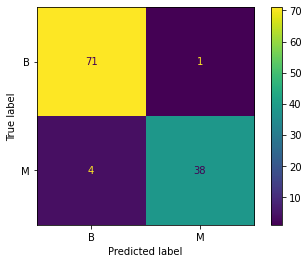

              precision    recall  f1-score   support

           B       0.95      0.99      0.97        72
           M       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114


# ====================

[[284   1]
 [ 10 160]]


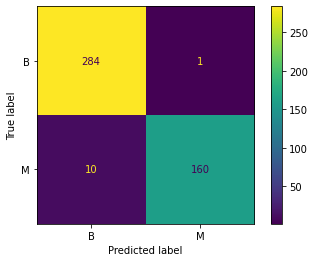

              precision    recall  f1-score   support

           B       0.97      1.00      0.98       285
           M       0.99      0.94      0.97       170

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.97       455
weighted avg       0.98      0.98      0.98       455



In [ ]:
y_pred_test = grid_knn.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

print("\n# ====================\n")

y_pred_train = grid_knn.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

Voltando pro recall:

In [ ]:
df = pd.read_csv("../datasets/breast_cancer.csv")

X = df.drop(columns="diagnosis")
y = df["diagnosis"]

# ====================

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42,
                                                    stratify=y)
# ====================

lista_etapas = [("std_scaler", StandardScaler()), 
                ("knn", KNeighborsClassifier())]

pipe = Pipeline(lista_etapas)

# ====================

# agora, tá estratificado!
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrica = make_scorer(recall_score, pos_label="M")

# ====================

param_grid = {"knn__weights" : ["uniform", "distance"],
              "knn__metric" : ["manhattan", "euclidean"],
              "knn__n_neighbors" : range(2, 21)}

# verbose=10 pra muitas combinações, os prints vão pro terminal
grid_knn = GridSearchCV(estimator=pipe, 
                        param_grid=param_grid,
                        scoring=metrica,
                        cv=splitter,
                        verbose=10)

grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 76 candidates, totalling 760 fits
[CV 1/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 1/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=0.941 total time=   0.0s
[CV 2/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 2/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 3/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 3/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=0.941 total time=   0.0s
[CV 4/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 4/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 5/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 5/10; 1/76] END knn__metric=manhatt

[CV 2/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 3/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 3/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 4/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 4/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 5/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 5/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 6/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 6/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 7/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__w

[CV 6/10; 9/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 7/10; 9/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform
[CV 7/10; 9/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=0.765 total time=   0.0s
[CV 8/10; 9/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform
[CV 8/10; 9/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 9/10; 9/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform
[CV 9/10; 9/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 10/10; 9/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform
[CV 10/10; 9/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 1/10; 10/76] START knn__metric=manhattan, knn__n_neighbors=6, knn

[CV 9/10; 13/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 10/10; 13/76] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform
[CV 10/10; 13/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 1/10; 14/76] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance
[CV 1/10; 14/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 2/10; 14/76] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance
[CV 2/10; 14/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance;, score=0.824 total time=   0.0s
[CV 3/10; 14/76] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance
[CV 3/10; 14/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 4/10; 14/76] START knn__metric=manhattan, knn__n_n

[CV 3/10; 18/76] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance
[CV 3/10; 18/76] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 4/10; 18/76] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance
[CV 4/10; 18/76] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 5/10; 18/76] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance
[CV 5/10; 18/76] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance;, score=0.882 total time=   0.0s
[CV 6/10; 18/76] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance
[CV 6/10; 18/76] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance;, score=0.824 total time=   0.0s
[CV 7/10; 18/76] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance
[CV 7/10; 18/76] END knn__metric=manhattan, knn__n_neighbors=10, knn__weigh

[CV 8/10; 22/76] END knn__metric=manhattan, knn__n_neighbors=12, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 9/10; 22/76] START knn__metric=manhattan, knn__n_neighbors=12, knn__weights=distance
[CV 9/10; 22/76] END knn__metric=manhattan, knn__n_neighbors=12, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 10/10; 22/76] START knn__metric=manhattan, knn__n_neighbors=12, knn__weights=distance
[CV 10/10; 22/76] END knn__metric=manhattan, knn__n_neighbors=12, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 1/10; 23/76] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform
[CV 1/10; 23/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform;, score=0.941 total time=   0.0s
[CV 2/10; 23/76] START knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform
[CV 2/10; 23/76] END knn__metric=manhattan, knn__n_neighbors=13, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 3/10; 23/76] START knn__metric=manhattan, 

[CV 1/10; 27/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform;, score=0.941 total time=   0.0s
[CV 2/10; 27/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform
[CV 2/10; 27/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 3/10; 27/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform
[CV 3/10; 27/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 4/10; 27/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform
[CV 4/10; 27/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 5/10; 27/76] START knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform
[CV 5/10; 27/76] END knn__metric=manhattan, knn__n_neighbors=15, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 6/10; 27/76] START knn__metric=manhattan, knn__n_

[CV 9/10; 31/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform
[CV 9/10; 31/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 10/10; 31/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform
[CV 10/10; 31/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 1/10; 32/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance
[CV 1/10; 32/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 2/10; 32/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance
[CV 2/10; 32/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance;, score=0.824 total time=   0.0s
[CV 3/10; 32/76] START knn__metric=manhattan, knn__n_neighbors=17, knn__weights=distance
[CV 3/10; 32/76] END knn__metric=manhattan, knn__n_neighbors=17, knn__weights

[CV 9/10; 35/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 10/10; 35/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform
[CV 10/10; 35/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 1/10; 36/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance
[CV 1/10; 36/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 2/10; 36/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance
[CV 2/10; 36/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=0.824 total time=   0.0s
[CV 3/10; 36/76] START knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance
[CV 3/10; 36/76] END knn__metric=manhattan, knn__n_neighbors=19, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 4/10; 36/76] START knn__metric=manhattan,

[CV 1/10; 40/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 2/10; 40/76] START knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance
[CV 2/10; 40/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance;, score=0.882 total time=   0.0s
[CV 3/10; 40/76] START knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance
[CV 3/10; 40/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 4/10; 40/76] START knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance
[CV 4/10; 40/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 5/10; 40/76] START knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance
[CV 5/10; 40/76] END knn__metric=euclidean, knn__n_neighbors=2, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 6/10; 40/76] START knn__metric=euclidean, knn__n_

[CV 2/10; 44/76] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance
[CV 2/10; 44/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance;, score=0.882 total time=   0.0s
[CV 3/10; 44/76] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance
[CV 3/10; 44/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 4/10; 44/76] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance
[CV 4/10; 44/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 5/10; 44/76] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance
[CV 5/10; 44/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 6/10; 44/76] START knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distance
[CV 6/10; 44/76] END knn__metric=euclidean, knn__n_neighbors=4, knn__weights=distanc

[CV 9/10; 48/76] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=distance
[CV 9/10; 48/76] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 10/10; 48/76] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=distance
[CV 10/10; 48/76] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 1/10; 49/76] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform
[CV 1/10; 49/76] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 2/10; 49/76] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform
[CV 2/10; 49/76] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 3/10; 49/76] START knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform
[CV 3/10; 49/76] END knn__metric=euclidean, knn__n_neighbors=7, knn__weights=uniform;, 

[CV 1/10; 53/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 2/10; 53/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform
[CV 2/10; 53/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 3/10; 53/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform
[CV 3/10; 53/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform;, score=0.941 total time=   0.0s
[CV 4/10; 53/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform
[CV 4/10; 53/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 5/10; 53/76] START knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform
[CV 5/10; 53/76] END knn__metric=euclidean, knn__n_neighbors=9, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 6/10; 53/76] START knn__metric=euclidean, knn__n_neighbors

[CV 10/10; 57/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=uniform;, score=0.882 total time=   0.0s
[CV 1/10; 58/76] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 1/10; 58/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 2/10; 58/76] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 2/10; 58/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.824 total time=   0.0s
[CV 3/10; 58/76] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 3/10; 58/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=0.941 total time=   0.0s
[CV 4/10; 58/76] START knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance
[CV 4/10; 58/76] END knn__metric=euclidean, knn__n_neighbors=11, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 5/10; 58/76] START knn__metric=euclidean

[CV 2/10; 62/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=0.824 total time=   0.0s
[CV 3/10; 62/76] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 3/10; 62/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 4/10; 62/76] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 4/10; 62/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 5/10; 62/76] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 5/10; 62/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=0.882 total time=   0.0s
[CV 6/10; 62/76] START knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance
[CV 6/10; 62/76] END knn__metric=euclidean, knn__n_neighbors=13, knn__weights=distance;, score=0.824 total time=   0.0s
[CV 7/10; 62/76] START knn__metric=euclidean

[CV 7/10; 66/76] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=0.765 total time=   0.0s
[CV 8/10; 66/76] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance
[CV 8/10; 66/76] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 9/10; 66/76] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance
[CV 9/10; 66/76] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=1.000 total time=   0.0s
[CV 10/10; 66/76] START knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance
[CV 10/10; 66/76] END knn__metric=euclidean, knn__n_neighbors=15, knn__weights=distance;, score=0.882 total time=   0.0s
[CV 1/10; 67/76] START knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform
[CV 1/10; 67/76] END knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform;, score=0.941 total time=   0.0s
[CV 2/10; 67/76] START knn__metric=euclidean

[CV 2/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 3/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 3/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=0.941 total time=   0.0s
[CV 4/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 4/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 5/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 5/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 6/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 6/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 7/10; 71/76] START knn__metric=euclidean, knn__n_

[CV 6/10; 75/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform
[CV 6/10; 75/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform;, score=0.824 total time=   0.0s
[CV 7/10; 75/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform
[CV 7/10; 75/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform;, score=0.765 total time=   0.0s
[CV 8/10; 75/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform
[CV 8/10; 75/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 9/10; 75/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform
[CV 9/10; 75/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform;, score=1.000 total time=   0.0s
[CV 10/10; 75/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform
[CV 10/10; 75/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=unif

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 21),
                         'knn__weights': ['uniform', 'distance']},
             scoring=make_scorer(recall_score, pos_label=M), verbose=10)

[[71  1]
 [ 3 39]]


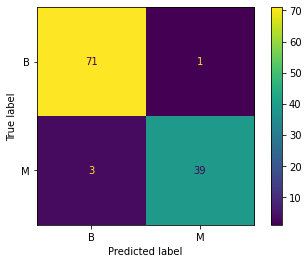

              precision    recall  f1-score   support

           B       0.96      0.99      0.97        72
           M       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114


# ====================

[[285   0]
 [  7 163]]


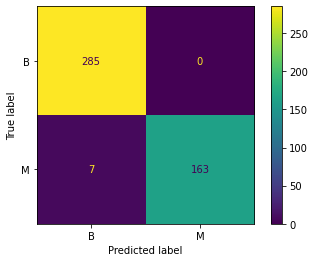

              precision    recall  f1-score   support

           B       0.98      1.00      0.99       285
           M       1.00      0.96      0.98       170

    accuracy                           0.98       455
   macro avg       0.99      0.98      0.98       455
weighted avg       0.98      0.98      0.98       455



In [ ]:
y_pred_test = grid_knn.predict(X_test)

print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

print("\n# ====================\n")

y_pred_train = grid_knn.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

________
_______
______

Sua vez! Faça agora uma estrutura de Pipeline + GS para o Logit, e depois compare o melhor logit com o melhor knn. Qual é o melhor modelo final?

In [ ]:
# pra casa
# teste l1, l2 e elastic net!!

____
____
____

## 3) KNN para regressão

O KNN é nosso primeiro exemplo de algoritmo que pode ser utilizado para ambos os problemas de classificação e regressão!

A ideia é bem simples: o target atribuído a uma nova observação é igual à **média do target das $k$ observações mais próximas**

<img src="https://bookdown.org/f100441618/bookdown-regresion/www/KNN.jpg" width=500>

Naturalmente, também para regressão o parâmetro $k$ e a métrica de distância são hiperparâmetros importantes:

<img src="https://i.stack.imgur.com/gAILq.png" width=500>

A classe no sklearn é a [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html). Dê uma olhada no User Guide e também no [RadiusNeighborsRegressor!](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsRegressor.html#sklearn.neighbors.RadiusNeighborsRegressor)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
df_houses = pd.read_csv("../datasets/house_prices.csv")
df_houses = df_houses.select_dtypes(include=np.number).dropna()

X = df_houses.drop(columns=["Id", "SalePrice"])
y = df_houses["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [ ]:
lista_etapas = [("std_scaler", StandardScaler()), 
                ("knn", KNeighborsRegressor())]

pipe = Pipeline(lista_etapas)

# ====================

# aqui, kfold normal pq nao tem classe pra estratificar
splitter = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = "neg_mean_absolute_error"

# ====================

param_grid = {"knn__weights" : ["uniform", "distance"],
              "knn__metric" : ["manhattan", "euclidean"],
              "knn__n_neighbors" : range(2, 21)}

# verbose=10 pra muitas combinações, os prints vão pro terminal
grid_knn_reg = GridSearchCV(estimator=pipe, 
                            param_grid=param_grid,
                            scoring=metrica,
                            cv=splitter,
                            verbose=10)

grid_knn_reg.fit(X_train, y_train)

Fitting 10 folds for each of 76 candidates, totalling 760 fits
[CV 1/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 1/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=-26932.550 total time=   0.0s
[CV 2/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 2/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=-23116.539 total time=   0.0s
[CV 3/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 3/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=-23705.983 total time=   0.0s
[CV 4/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 4/10; 1/76] END knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform;, score=-28354.044 total time=   0.0s
[CV 5/10; 1/76] START knn__metric=manhattan, knn__n_neighbors=2, knn__weights=uniform
[CV 5/10; 1/76] END

[CV 6/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=-16855.194 total time=   0.0s
[CV 7/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 7/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=-18972.831 total time=   0.0s
[CV 8/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 8/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=-19153.093 total time=   0.0s
[CV 9/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 9/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=-25155.801 total time=   0.0s
[CV 10/10; 5/76] START knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform
[CV 10/10; 5/76] END knn__metric=manhattan, knn__n_neighbors=4, knn__weights=uniform;, score=-19693.371 total time=   0.0s
[CV 1/10; 6/76] START knn__metric=manhattan,

[CV 5/10; 9/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=-20330.543 total time=   0.0s
[CV 6/10; 9/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform
[CV 6/10; 9/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=-15831.633 total time=   0.0s
[CV 7/10; 9/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform
[CV 7/10; 9/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=-18901.199 total time=   0.0s
[CV 8/10; 9/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform
[CV 8/10; 9/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=-20324.699 total time=   0.0s
[CV 9/10; 9/76] START knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform
[CV 9/10; 9/76] END knn__metric=manhattan, knn__n_neighbors=6, knn__weights=uniform;, score=-23194.393 total time=   0.0s
[CV 10/10; 9/76] START knn__metric=manhattan, 

[CV 4/10; 13/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform;, score=-25143.407 total time=   0.0s
[CV 5/10; 13/76] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform
[CV 5/10; 13/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform;, score=-18584.381 total time=   0.0s
[CV 6/10; 13/76] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform
[CV 6/10; 13/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform;, score=-16288.326 total time=   0.0s
[CV 7/10; 13/76] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform
[CV 7/10; 13/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform;, score=-18143.223 total time=   0.0s
[CV 8/10; 13/76] START knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform
[CV 8/10; 13/76] END knn__metric=manhattan, knn__n_neighbors=8, knn__weights=uniform;, score=-21120.757 total time=   0.0s
[CV 9/10; 13/76] START knn__metric=ma

[CV 7/10; 17/76] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform;, score=-18815.471 total time=   0.0s
[CV 8/10; 17/76] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform
[CV 8/10; 17/76] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform;, score=-21003.175 total time=   0.0s
[CV 9/10; 17/76] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform
[CV 9/10; 17/76] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform;, score=-23630.922 total time=   0.0s
[CV 10/10; 17/76] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform
[CV 10/10; 17/76] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=uniform;, score=-20393.155 total time=   0.0s
[CV 1/10; 18/76] START knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance
[CV 1/10; 18/76] END knn__metric=manhattan, knn__n_neighbors=10, knn__weights=distance;, score=-21727.375 total time=   0.0s
[CV 2/10; 18/76] START k

[CV 6/10; 21/76] END knn__metric=manhattan, knn__n_neighbors=12, knn__weights=uniform;, score=-15459.534 total time=   0.0s
[CV 7/10; 21/76] START knn__metric=manhattan, knn__n_neighbors=12, knn__weights=uniform
[CV 7/10; 21/76] END knn__metric=manhattan, knn__n_neighbors=12, knn__weights=uniform;, score=-18729.182 total time=   0.0s
[CV 8/10; 21/76] START knn__metric=manhattan, knn__n_neighbors=12, knn__weights=uniform
[CV 8/10; 21/76] END knn__metric=manhattan, knn__n_neighbors=12, knn__weights=uniform;, score=-20963.419 total time=   0.0s
[CV 9/10; 21/76] START knn__metric=manhattan, knn__n_neighbors=12, knn__weights=uniform
[CV 9/10; 21/76] END knn__metric=manhattan, knn__n_neighbors=12, knn__weights=uniform;, score=-23902.573 total time=   0.0s
[CV 10/10; 21/76] START knn__metric=manhattan, knn__n_neighbors=12, knn__weights=uniform
[CV 10/10; 21/76] END knn__metric=manhattan, knn__n_neighbors=12, knn__weights=uniform;, score=-20653.865 total time=   0.0s
[CV 1/10; 22/76] START knn

[CV 10/10; 25/76] START knn__metric=manhattan, knn__n_neighbors=14, knn__weights=uniform
[CV 10/10; 25/76] END knn__metric=manhattan, knn__n_neighbors=14, knn__weights=uniform;, score=-21400.307 total time=   0.0s
[CV 1/10; 26/76] START knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance
[CV 1/10; 26/76] END knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance;, score=-21385.236 total time=   0.0s
[CV 2/10; 26/76] START knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance
[CV 2/10; 26/76] END knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance;, score=-21529.928 total time=   0.0s
[CV 3/10; 26/76] START knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance
[CV 3/10; 26/76] END knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance;, score=-21184.054 total time=   0.0s
[CV 4/10; 26/76] START knn__metric=manhattan, knn__n_neighbors=14, knn__weights=distance
[CV 4/10; 26/76] END knn__metric=manhattan, knn__n_neig

[CV 8/10; 29/76] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=uniform;, score=-22453.756 total time=   0.0s
[CV 9/10; 29/76] START knn__metric=manhattan, knn__n_neighbors=16, knn__weights=uniform
[CV 9/10; 29/76] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=uniform;, score=-24397.454 total time=   0.0s
[CV 10/10; 29/76] START knn__metric=manhattan, knn__n_neighbors=16, knn__weights=uniform
[CV 10/10; 29/76] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=uniform;, score=-21161.456 total time=   0.0s
[CV 1/10; 30/76] START knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance
[CV 1/10; 30/76] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance;, score=-21927.629 total time=   0.0s
[CV 2/10; 30/76] START knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance
[CV 2/10; 30/76] END knn__metric=manhattan, knn__n_neighbors=16, knn__weights=distance;, score=-22213.526 total time=   0.0s
[CV 3/10; 30/76] START

[CV 10/10; 33/76] END knn__metric=manhattan, knn__n_neighbors=18, knn__weights=uniform;, score=-20321.953 total time=   0.0s
[CV 1/10; 34/76] START knn__metric=manhattan, knn__n_neighbors=18, knn__weights=distance
[CV 1/10; 34/76] END knn__metric=manhattan, knn__n_neighbors=18, knn__weights=distance;, score=-21790.701 total time=   0.0s
[CV 2/10; 34/76] START knn__metric=manhattan, knn__n_neighbors=18, knn__weights=distance
[CV 2/10; 34/76] END knn__metric=manhattan, knn__n_neighbors=18, knn__weights=distance;, score=-22315.660 total time=   0.0s
[CV 3/10; 34/76] START knn__metric=manhattan, knn__n_neighbors=18, knn__weights=distance
[CV 3/10; 34/76] END knn__metric=manhattan, knn__n_neighbors=18, knn__weights=distance;, score=-22044.760 total time=   0.0s
[CV 4/10; 34/76] START knn__metric=manhattan, knn__n_neighbors=18, knn__weights=distance
[CV 4/10; 34/76] END knn__metric=manhattan, knn__n_neighbors=18, knn__weights=distance;, score=-24745.256 total time=   0.0s
[CV 5/10; 34/76] ST

[CV 4/10; 38/76] END knn__metric=manhattan, knn__n_neighbors=20, knn__weights=distance;, score=-24873.089 total time=   0.0s
[CV 5/10; 38/76] START knn__metric=manhattan, knn__n_neighbors=20, knn__weights=distance
[CV 5/10; 38/76] END knn__metric=manhattan, knn__n_neighbors=20, knn__weights=distance;, score=-20248.482 total time=   0.0s
[CV 6/10; 38/76] START knn__metric=manhattan, knn__n_neighbors=20, knn__weights=distance
[CV 6/10; 38/76] END knn__metric=manhattan, knn__n_neighbors=20, knn__weights=distance;, score=-14431.126 total time=   0.0s
[CV 7/10; 38/76] START knn__metric=manhattan, knn__n_neighbors=20, knn__weights=distance
[CV 7/10; 38/76] END knn__metric=manhattan, knn__n_neighbors=20, knn__weights=distance;, score=-19136.247 total time=   0.0s
[CV 8/10; 38/76] START knn__metric=manhattan, knn__n_neighbors=20, knn__weights=distance
[CV 8/10; 38/76] END knn__metric=manhattan, knn__n_neighbors=20, knn__weights=distance;, score=-21948.561 total time=   0.0s
[CV 9/10; 38/76] ST

[CV 4/10; 42/76] START knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance
[CV 4/10; 42/76] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance;, score=-29080.903 total time=   0.0s
[CV 5/10; 42/76] START knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance
[CV 5/10; 42/76] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance;, score=-22645.795 total time=   0.0s
[CV 6/10; 42/76] START knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance
[CV 6/10; 42/76] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance;, score=-19347.741 total time=   0.0s
[CV 7/10; 42/76] START knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance
[CV 7/10; 42/76] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance;, score=-23368.583 total time=   0.0s
[CV 8/10; 42/76] START knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance
[CV 8/10; 42/76] END knn__metric=euclidean, knn__n_neighbors=3, 

[CV 9/10; 46/76] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance;, score=-29342.286 total time=   0.0s
[CV 10/10; 46/76] START knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance
[CV 10/10; 46/76] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance;, score=-23239.199 total time=   0.0s
[CV 1/10; 47/76] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform
[CV 1/10; 47/76] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform;, score=-24521.802 total time=   0.0s
[CV 2/10; 47/76] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform
[CV 2/10; 47/76] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform;, score=-22593.870 total time=   0.0s
[CV 3/10; 47/76] START knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform
[CV 3/10; 47/76] END knn__metric=euclidean, knn__n_neighbors=6, knn__weights=uniform;, score=-22342.587 total time=   0.0s
[CV 4/10; 47/76] START knn__metr

[CV 1/10; 51/76] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=uniform;, score=-24311.797 total time=   0.0s
[CV 2/10; 51/76] START knn__metric=euclidean, knn__n_neighbors=8, knn__weights=uniform
[CV 2/10; 51/76] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=uniform;, score=-21932.171 total time=   0.0s
[CV 3/10; 51/76] START knn__metric=euclidean, knn__n_neighbors=8, knn__weights=uniform
[CV 3/10; 51/76] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=uniform;, score=-22416.854 total time=   0.0s
[CV 4/10; 51/76] START knn__metric=euclidean, knn__n_neighbors=8, knn__weights=uniform
[CV 4/10; 51/76] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=uniform;, score=-25643.101 total time=   0.0s
[CV 5/10; 51/76] START knn__metric=euclidean, knn__n_neighbors=8, knn__weights=uniform
[CV 5/10; 51/76] END knn__metric=euclidean, knn__n_neighbors=8, knn__weights=uniform;, score=-21398.407 total time=   0.0s
[CV 6/10; 51/76] START knn__metric=eu

[CV 6/10; 55/76] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform;, score=-17705.907 total time=   0.0s
[CV 7/10; 55/76] START knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform
[CV 7/10; 55/76] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform;, score=-20221.116 total time=   0.0s
[CV 8/10; 55/76] START knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform
[CV 8/10; 55/76] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform;, score=-24214.122 total time=   0.0s
[CV 9/10; 55/76] START knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform
[CV 9/10; 55/76] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform;, score=-25591.601 total time=   0.0s
[CV 10/10; 55/76] START knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform
[CV 10/10; 55/76] END knn__metric=euclidean, knn__n_neighbors=10, knn__weights=uniform;, score=-23835.490 total time=   0.0s
[CV 1/10; 56/76] START knn

[CV 4/10; 59/76] END knn__metric=euclidean, knn__n_neighbors=12, knn__weights=uniform;, score=-25543.879 total time=   0.0s
[CV 5/10; 59/76] START knn__metric=euclidean, knn__n_neighbors=12, knn__weights=uniform
[CV 5/10; 59/76] END knn__metric=euclidean, knn__n_neighbors=12, knn__weights=uniform;, score=-20442.254 total time=   0.0s
[CV 6/10; 59/76] START knn__metric=euclidean, knn__n_neighbors=12, knn__weights=uniform
[CV 6/10; 59/76] END knn__metric=euclidean, knn__n_neighbors=12, knn__weights=uniform;, score=-17353.394 total time=   0.0s
[CV 7/10; 59/76] START knn__metric=euclidean, knn__n_neighbors=12, knn__weights=uniform
[CV 7/10; 59/76] END knn__metric=euclidean, knn__n_neighbors=12, knn__weights=uniform;, score=-20000.535 total time=   0.0s
[CV 8/10; 59/76] START knn__metric=euclidean, knn__n_neighbors=12, knn__weights=uniform
[CV 8/10; 59/76] END knn__metric=euclidean, knn__n_neighbors=12, knn__weights=uniform;, score=-23678.586 total time=   0.0s
[CV 9/10; 59/76] START knn__

[CV 3/10; 63/76] END knn__metric=euclidean, knn__n_neighbors=14, knn__weights=uniform;, score=-22928.148 total time=   0.0s
[CV 4/10; 63/76] START knn__metric=euclidean, knn__n_neighbors=14, knn__weights=uniform
[CV 4/10; 63/76] END knn__metric=euclidean, knn__n_neighbors=14, knn__weights=uniform;, score=-25708.229 total time=   0.0s
[CV 5/10; 63/76] START knn__metric=euclidean, knn__n_neighbors=14, knn__weights=uniform
[CV 5/10; 63/76] END knn__metric=euclidean, knn__n_neighbors=14, knn__weights=uniform;, score=-20631.151 total time=   0.0s
[CV 6/10; 63/76] START knn__metric=euclidean, knn__n_neighbors=14, knn__weights=uniform
[CV 6/10; 63/76] END knn__metric=euclidean, knn__n_neighbors=14, knn__weights=uniform;, score=-17109.294 total time=   0.0s
[CV 7/10; 63/76] START knn__metric=euclidean, knn__n_neighbors=14, knn__weights=uniform
[CV 7/10; 63/76] END knn__metric=euclidean, knn__n_neighbors=14, knn__weights=uniform;, score=-20342.703 total time=   0.0s
[CV 8/10; 63/76] START knn__

[CV 4/10; 67/76] END knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform;, score=-26038.362 total time=   0.0s
[CV 5/10; 67/76] START knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform
[CV 5/10; 67/76] END knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform;, score=-21191.384 total time=   0.0s
[CV 6/10; 67/76] START knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform
[CV 6/10; 67/76] END knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform;, score=-16333.576 total time=   0.0s
[CV 7/10; 67/76] START knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform
[CV 7/10; 67/76] END knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform;, score=-20636.768 total time=   0.0s
[CV 8/10; 67/76] START knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform
[CV 8/10; 67/76] END knn__metric=euclidean, knn__n_neighbors=16, knn__weights=uniform;, score=-23939.140 total time=   0.0s
[CV 9/10; 67/76] START knn__

[CV 4/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=-27253.030 total time=   0.0s
[CV 5/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 5/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=-21159.485 total time=   0.0s
[CV 6/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 6/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=-16537.443 total time=   0.0s
[CV 7/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 7/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=-20815.148 total time=   0.0s
[CV 8/10; 71/76] START knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform
[CV 8/10; 71/76] END knn__metric=euclidean, knn__n_neighbors=18, knn__weights=uniform;, score=-24263.041 total time=   0.0s
[CV 9/10; 71/76] START knn__

[CV 10/10; 75/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=uniform;, score=-23041.397 total time=   0.0s
[CV 1/10; 76/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance
[CV 1/10; 76/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance;, score=-22595.971 total time=   0.0s
[CV 2/10; 76/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance
[CV 2/10; 76/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance;, score=-23873.095 total time=   0.0s
[CV 3/10; 76/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance
[CV 3/10; 76/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance;, score=-23106.689 total time=   0.0s
[CV 4/10; 76/76] START knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance
[CV 4/10; 76/76] END knn__metric=euclidean, knn__n_neighbors=20, knn__weights=distance;, score=-26702.380 total time=   0.0s
[CV 5/10; 76/76] ST

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(2, 21),
                         'knn__weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error', verbose=10)

In [ ]:
grid_knn_reg.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 8, 'knn__weights': 'distance'}

In [ ]:
grid_knn_reg.best_score_

-20297.192189179004

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# predições de treino
y_pred_train = grid_knn_reg.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

# predições de teste
y_pred_test = grid_knn_reg.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}") 


Métricas de treino:

R^2: 1.00
MAE: 0.00
RMSE: 0.00

Métricas de teste:

R^2: 0.81
MAE: 20875.14
RMSE: 38970.95


Limitando o k, pra fugir de overfitting

In [ ]:
lista_etapas = [("std_scaler", StandardScaler()), 
                ("knn", KNeighborsRegressor())]

pipe = Pipeline(lista_etapas)

# ====================

# aqui, kfold normal pq nao tem classe pra estratificar
splitter = KFold(n_splits=10, shuffle=True, random_state=42)

metrica = "neg_mean_absolute_error"

# ====================

param_grid = {"knn__weights" : ["uniform"],
              "knn__metric" : ["manhattan", "euclidean"],
              "knn__n_neighbors" : range(50, 100)}

# verbose=10 pra muitas combinações, os prints vão pro terminal
grid_knn_reg = GridSearchCV(estimator=pipe, 
                            param_grid=param_grid,
                            scoring=metrica,
                            cv=splitter,
                            verbose=10)

grid_knn_reg.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10; 1/100] START knn__metric=manhattan, knn__n_neighbors=50, knn__weights=uniform
[CV 1/10; 1/100] END knn__metric=manhattan, knn__n_neighbors=50, knn__weights=uniform;, score=-22931.016 total time=   0.0s
[CV 2/10; 1/100] START knn__metric=manhattan, knn__n_neighbors=50, knn__weights=uniform
[CV 2/10; 1/100] END knn__metric=manhattan, knn__n_neighbors=50, knn__weights=uniform;, score=-25581.902 total time=   0.0s
[CV 3/10; 1/100] START knn__metric=manhattan, knn__n_neighbors=50, knn__weights=uniform
[CV 3/10; 1/100] END knn__metric=manhattan, knn__n_neighbors=50, knn__weights=uniform;, score=-25554.409 total time=   0.0s
[CV 4/10; 1/100] START knn__metric=manhattan, knn__n_neighbors=50, knn__weights=uniform
[CV 4/10; 1/100] END knn__metric=manhattan, knn__n_neighbors=50, knn__weights=uniform;, score=-26511.032 total time=   0.0s
[CV 5/10; 1/100] START knn__metric=manhattan, knn__n_neighbors=50, knn__weights=uniform

[CV 9/10; 4/100] END knn__metric=manhattan, knn__n_neighbors=53, knn__weights=uniform;, score=-25016.882 total time=   0.0s
[CV 10/10; 4/100] START knn__metric=manhattan, knn__n_neighbors=53, knn__weights=uniform
[CV 10/10; 4/100] END knn__metric=manhattan, knn__n_neighbors=53, knn__weights=uniform;, score=-23494.428 total time=   0.0s
[CV 1/10; 5/100] START knn__metric=manhattan, knn__n_neighbors=54, knn__weights=uniform
[CV 1/10; 5/100] END knn__metric=manhattan, knn__n_neighbors=54, knn__weights=uniform;, score=-23027.075 total time=   0.0s
[CV 2/10; 5/100] START knn__metric=manhattan, knn__n_neighbors=54, knn__weights=uniform
[CV 2/10; 5/100] END knn__metric=manhattan, knn__n_neighbors=54, knn__weights=uniform;, score=-25852.305 total time=   0.0s
[CV 3/10; 5/100] START knn__metric=manhattan, knn__n_neighbors=54, knn__weights=uniform
[CV 3/10; 5/100] END knn__metric=manhattan, knn__n_neighbors=54, knn__weights=uniform;, score=-25995.309 total time=   0.0s
[CV 4/10; 5/100] START knn

[CV 10/10; 8/100] END knn__metric=manhattan, knn__n_neighbors=57, knn__weights=uniform;, score=-23855.681 total time=   0.0s
[CV 1/10; 9/100] START knn__metric=manhattan, knn__n_neighbors=58, knn__weights=uniform
[CV 1/10; 9/100] END knn__metric=manhattan, knn__n_neighbors=58, knn__weights=uniform;, score=-23249.918 total time=   0.0s
[CV 2/10; 9/100] START knn__metric=manhattan, knn__n_neighbors=58, knn__weights=uniform
[CV 2/10; 9/100] END knn__metric=manhattan, knn__n_neighbors=58, knn__weights=uniform;, score=-26049.809 total time=   0.0s
[CV 3/10; 9/100] START knn__metric=manhattan, knn__n_neighbors=58, knn__weights=uniform
[CV 3/10; 9/100] END knn__metric=manhattan, knn__n_neighbors=58, knn__weights=uniform;, score=-26081.213 total time=   0.0s
[CV 4/10; 9/100] START knn__metric=manhattan, knn__n_neighbors=58, knn__weights=uniform
[CV 4/10; 9/100] END knn__metric=manhattan, knn__n_neighbors=58, knn__weights=uniform;, score=-26908.737 total time=   0.0s
[CV 5/10; 9/100] START knn_

[CV 9/10; 12/100] END knn__metric=manhattan, knn__n_neighbors=61, knn__weights=uniform;, score=-25457.940 total time=   0.0s
[CV 10/10; 12/100] START knn__metric=manhattan, knn__n_neighbors=61, knn__weights=uniform
[CV 10/10; 12/100] END knn__metric=manhattan, knn__n_neighbors=61, knn__weights=uniform;, score=-24061.087 total time=   0.0s
[CV 1/10; 13/100] START knn__metric=manhattan, knn__n_neighbors=62, knn__weights=uniform
[CV 1/10; 13/100] END knn__metric=manhattan, knn__n_neighbors=62, knn__weights=uniform;, score=-23244.913 total time=   0.0s
[CV 2/10; 13/100] START knn__metric=manhattan, knn__n_neighbors=62, knn__weights=uniform
[CV 2/10; 13/100] END knn__metric=manhattan, knn__n_neighbors=62, knn__weights=uniform;, score=-26447.844 total time=   0.0s
[CV 3/10; 13/100] START knn__metric=manhattan, knn__n_neighbors=62, knn__weights=uniform
[CV 3/10; 13/100] END knn__metric=manhattan, knn__n_neighbors=62, knn__weights=uniform;, score=-26624.135 total time=   0.0s
[CV 4/10; 13/100]

[CV 10/10; 16/100] END knn__metric=manhattan, knn__n_neighbors=65, knn__weights=uniform;, score=-24225.244 total time=   0.0s
[CV 1/10; 17/100] START knn__metric=manhattan, knn__n_neighbors=66, knn__weights=uniform
[CV 1/10; 17/100] END knn__metric=manhattan, knn__n_neighbors=66, knn__weights=uniform;, score=-23515.946 total time=   0.0s
[CV 2/10; 17/100] START knn__metric=manhattan, knn__n_neighbors=66, knn__weights=uniform
[CV 2/10; 17/100] END knn__metric=manhattan, knn__n_neighbors=66, knn__weights=uniform;, score=-26855.659 total time=   0.0s
[CV 3/10; 17/100] START knn__metric=manhattan, knn__n_neighbors=66, knn__weights=uniform
[CV 3/10; 17/100] END knn__metric=manhattan, knn__n_neighbors=66, knn__weights=uniform;, score=-26910.911 total time=   0.0s
[CV 4/10; 17/100] START knn__metric=manhattan, knn__n_neighbors=66, knn__weights=uniform
[CV 4/10; 17/100] END knn__metric=manhattan, knn__n_neighbors=66, knn__weights=uniform;, score=-27449.825 total time=   0.0s
[CV 5/10; 17/100] 

[CV 8/10; 20/100] END knn__metric=manhattan, knn__n_neighbors=69, knn__weights=uniform;, score=-25331.830 total time=   0.0s
[CV 9/10; 20/100] START knn__metric=manhattan, knn__n_neighbors=69, knn__weights=uniform
[CV 9/10; 20/100] END knn__metric=manhattan, knn__n_neighbors=69, knn__weights=uniform;, score=-25755.206 total time=   0.0s
[CV 10/10; 20/100] START knn__metric=manhattan, knn__n_neighbors=69, knn__weights=uniform
[CV 10/10; 20/100] END knn__metric=manhattan, knn__n_neighbors=69, knn__weights=uniform;, score=-24530.948 total time=   0.0s
[CV 1/10; 21/100] START knn__metric=manhattan, knn__n_neighbors=70, knn__weights=uniform
[CV 1/10; 21/100] END knn__metric=manhattan, knn__n_neighbors=70, knn__weights=uniform;, score=-23548.105 total time=   0.0s
[CV 2/10; 21/100] START knn__metric=manhattan, knn__n_neighbors=70, knn__weights=uniform
[CV 2/10; 21/100] END knn__metric=manhattan, knn__n_neighbors=70, knn__weights=uniform;, score=-27325.349 total time=   0.0s
[CV 3/10; 21/100]

[CV 1/10; 25/100] END knn__metric=manhattan, knn__n_neighbors=74, knn__weights=uniform;, score=-23475.582 total time=   0.0s
[CV 2/10; 25/100] START knn__metric=manhattan, knn__n_neighbors=74, knn__weights=uniform
[CV 2/10; 25/100] END knn__metric=manhattan, knn__n_neighbors=74, knn__weights=uniform;, score=-27606.608 total time=   0.0s
[CV 3/10; 25/100] START knn__metric=manhattan, knn__n_neighbors=74, knn__weights=uniform
[CV 3/10; 25/100] END knn__metric=manhattan, knn__n_neighbors=74, knn__weights=uniform;, score=-27504.620 total time=   0.0s
[CV 4/10; 25/100] START knn__metric=manhattan, knn__n_neighbors=74, knn__weights=uniform
[CV 4/10; 25/100] END knn__metric=manhattan, knn__n_neighbors=74, knn__weights=uniform;, score=-27580.799 total time=   0.0s
[CV 5/10; 25/100] START knn__metric=manhattan, knn__n_neighbors=74, knn__weights=uniform
[CV 5/10; 25/100] END knn__metric=manhattan, knn__n_neighbors=74, knn__weights=uniform;, score=-22780.969 total time=   0.0s
[CV 6/10; 25/100] S

[CV 3/10; 29/100] END knn__metric=manhattan, knn__n_neighbors=78, knn__weights=uniform;, score=-27990.249 total time=   0.0s
[CV 4/10; 29/100] START knn__metric=manhattan, knn__n_neighbors=78, knn__weights=uniform
[CV 4/10; 29/100] END knn__metric=manhattan, knn__n_neighbors=78, knn__weights=uniform;, score=-27973.707 total time=   0.0s
[CV 5/10; 29/100] START knn__metric=manhattan, knn__n_neighbors=78, knn__weights=uniform
[CV 5/10; 29/100] END knn__metric=manhattan, knn__n_neighbors=78, knn__weights=uniform;, score=-23190.067 total time=   0.0s
[CV 6/10; 29/100] START knn__metric=manhattan, knn__n_neighbors=78, knn__weights=uniform
[CV 6/10; 29/100] END knn__metric=manhattan, knn__n_neighbors=78, knn__weights=uniform;, score=-17580.927 total time=   0.0s
[CV 7/10; 29/100] START knn__metric=manhattan, knn__n_neighbors=78, knn__weights=uniform
[CV 7/10; 29/100] END knn__metric=manhattan, knn__n_neighbors=78, knn__weights=uniform;, score=-24338.023 total time=   0.0s
[CV 8/10; 29/100] S

[CV 2/10; 33/100] END knn__metric=manhattan, knn__n_neighbors=82, knn__weights=uniform;, score=-27622.545 total time=   0.0s
[CV 3/10; 33/100] START knn__metric=manhattan, knn__n_neighbors=82, knn__weights=uniform
[CV 3/10; 33/100] END knn__metric=manhattan, knn__n_neighbors=82, knn__weights=uniform;, score=-28384.021 total time=   0.0s
[CV 4/10; 33/100] START knn__metric=manhattan, knn__n_neighbors=82, knn__weights=uniform
[CV 4/10; 33/100] END knn__metric=manhattan, knn__n_neighbors=82, knn__weights=uniform;, score=-28244.763 total time=   0.0s
[CV 5/10; 33/100] START knn__metric=manhattan, knn__n_neighbors=82, knn__weights=uniform
[CV 5/10; 33/100] END knn__metric=manhattan, knn__n_neighbors=82, knn__weights=uniform;, score=-23277.061 total time=   0.0s
[CV 6/10; 33/100] START knn__metric=manhattan, knn__n_neighbors=82, knn__weights=uniform
[CV 6/10; 33/100] END knn__metric=manhattan, knn__n_neighbors=82, knn__weights=uniform;, score=-17773.342 total time=   0.0s
[CV 7/10; 33/100] S

[CV 10/10; 36/100] END knn__metric=manhattan, knn__n_neighbors=85, knn__weights=uniform;, score=-25186.463 total time=   0.0s
[CV 1/10; 37/100] START knn__metric=manhattan, knn__n_neighbors=86, knn__weights=uniform
[CV 1/10; 37/100] END knn__metric=manhattan, knn__n_neighbors=86, knn__weights=uniform;, score=-23771.421 total time=   0.0s
[CV 2/10; 37/100] START knn__metric=manhattan, knn__n_neighbors=86, knn__weights=uniform
[CV 2/10; 37/100] END knn__metric=manhattan, knn__n_neighbors=86, knn__weights=uniform;, score=-27880.717 total time=   0.0s
[CV 3/10; 37/100] START knn__metric=manhattan, knn__n_neighbors=86, knn__weights=uniform
[CV 3/10; 37/100] END knn__metric=manhattan, knn__n_neighbors=86, knn__weights=uniform;, score=-28592.824 total time=   0.0s
[CV 4/10; 37/100] START knn__metric=manhattan, knn__n_neighbors=86, knn__weights=uniform
[CV 4/10; 37/100] END knn__metric=manhattan, knn__n_neighbors=86, knn__weights=uniform;, score=-28266.605 total time=   0.0s
[CV 5/10; 37/100] 

[CV 9/10; 40/100] END knn__metric=manhattan, knn__n_neighbors=89, knn__weights=uniform;, score=-26745.156 total time=   0.0s
[CV 10/10; 40/100] START knn__metric=manhattan, knn__n_neighbors=89, knn__weights=uniform
[CV 10/10; 40/100] END knn__metric=manhattan, knn__n_neighbors=89, knn__weights=uniform;, score=-25336.539 total time=   0.0s
[CV 1/10; 41/100] START knn__metric=manhattan, knn__n_neighbors=90, knn__weights=uniform
[CV 1/10; 41/100] END knn__metric=manhattan, knn__n_neighbors=90, knn__weights=uniform;, score=-23780.244 total time=   0.0s
[CV 2/10; 41/100] START knn__metric=manhattan, knn__n_neighbors=90, knn__weights=uniform
[CV 2/10; 41/100] END knn__metric=manhattan, knn__n_neighbors=90, knn__weights=uniform;, score=-27956.544 total time=   0.0s
[CV 3/10; 41/100] START knn__metric=manhattan, knn__n_neighbors=90, knn__weights=uniform
[CV 3/10; 41/100] END knn__metric=manhattan, knn__n_neighbors=90, knn__weights=uniform;, score=-28727.204 total time=   0.0s
[CV 4/10; 41/100]

[CV 9/10; 44/100] START knn__metric=manhattan, knn__n_neighbors=93, knn__weights=uniform
[CV 9/10; 44/100] END knn__metric=manhattan, knn__n_neighbors=93, knn__weights=uniform;, score=-26741.427 total time=   0.0s
[CV 10/10; 44/100] START knn__metric=manhattan, knn__n_neighbors=93, knn__weights=uniform
[CV 10/10; 44/100] END knn__metric=manhattan, knn__n_neighbors=93, knn__weights=uniform;, score=-25352.468 total time=   0.0s
[CV 1/10; 45/100] START knn__metric=manhattan, knn__n_neighbors=94, knn__weights=uniform
[CV 1/10; 45/100] END knn__metric=manhattan, knn__n_neighbors=94, knn__weights=uniform;, score=-23993.383 total time=   0.0s
[CV 2/10; 45/100] START knn__metric=manhattan, knn__n_neighbors=94, knn__weights=uniform
[CV 2/10; 45/100] END knn__metric=manhattan, knn__n_neighbors=94, knn__weights=uniform;, score=-28117.240 total time=   0.0s
[CV 3/10; 45/100] START knn__metric=manhattan, knn__n_neighbors=94, knn__weights=uniform
[CV 3/10; 45/100] END knn__metric=manhattan, knn__n_n

[CV 6/10; 49/100] END knn__metric=manhattan, knn__n_neighbors=98, knn__weights=uniform;, score=-18078.710 total time=   0.0s
[CV 7/10; 49/100] START knn__metric=manhattan, knn__n_neighbors=98, knn__weights=uniform
[CV 7/10; 49/100] END knn__metric=manhattan, knn__n_neighbors=98, knn__weights=uniform;, score=-25091.422 total time=   0.0s
[CV 8/10; 49/100] START knn__metric=manhattan, knn__n_neighbors=98, knn__weights=uniform
[CV 8/10; 49/100] END knn__metric=manhattan, knn__n_neighbors=98, knn__weights=uniform;, score=-26371.070 total time=   0.0s
[CV 9/10; 49/100] START knn__metric=manhattan, knn__n_neighbors=98, knn__weights=uniform
[CV 9/10; 49/100] END knn__metric=manhattan, knn__n_neighbors=98, knn__weights=uniform;, score=-26950.622 total time=   0.0s
[CV 10/10; 49/100] START knn__metric=manhattan, knn__n_neighbors=98, knn__weights=uniform
[CV 10/10; 49/100] END knn__metric=manhattan, knn__n_neighbors=98, knn__weights=uniform;, score=-25569.732 total time=   0.0s
[CV 1/10; 50/100]

[CV 1/10; 54/100] END knn__metric=euclidean, knn__n_neighbors=53, knn__weights=uniform;, score=-24164.970 total time=   0.0s
[CV 2/10; 54/100] START knn__metric=euclidean, knn__n_neighbors=53, knn__weights=uniform
[CV 2/10; 54/100] END knn__metric=euclidean, knn__n_neighbors=53, knn__weights=uniform;, score=-27094.681 total time=   0.0s
[CV 3/10; 54/100] START knn__metric=euclidean, knn__n_neighbors=53, knn__weights=uniform
[CV 3/10; 54/100] END knn__metric=euclidean, knn__n_neighbors=53, knn__weights=uniform;, score=-27240.875 total time=   0.0s
[CV 4/10; 54/100] START knn__metric=euclidean, knn__n_neighbors=53, knn__weights=uniform
[CV 4/10; 54/100] END knn__metric=euclidean, knn__n_neighbors=53, knn__weights=uniform;, score=-28907.408 total time=   0.0s
[CV 5/10; 54/100] START knn__metric=euclidean, knn__n_neighbors=53, knn__weights=uniform
[CV 5/10; 54/100] END knn__metric=euclidean, knn__n_neighbors=53, knn__weights=uniform;, score=-22613.173 total time=   0.0s
[CV 6/10; 54/100] S

[CV 10/10; 57/100] END knn__metric=euclidean, knn__n_neighbors=56, knn__weights=uniform;, score=-26012.027 total time=   0.0s
[CV 1/10; 58/100] START knn__metric=euclidean, knn__n_neighbors=57, knn__weights=uniform
[CV 1/10; 58/100] END knn__metric=euclidean, knn__n_neighbors=57, knn__weights=uniform;, score=-24623.204 total time=   0.0s
[CV 2/10; 58/100] START knn__metric=euclidean, knn__n_neighbors=57, knn__weights=uniform
[CV 2/10; 58/100] END knn__metric=euclidean, knn__n_neighbors=57, knn__weights=uniform;, score=-27694.425 total time=   0.0s
[CV 3/10; 58/100] START knn__metric=euclidean, knn__n_neighbors=57, knn__weights=uniform
[CV 3/10; 58/100] END knn__metric=euclidean, knn__n_neighbors=57, knn__weights=uniform;, score=-27550.141 total time=   0.0s
[CV 4/10; 58/100] START knn__metric=euclidean, knn__n_neighbors=57, knn__weights=uniform
[CV 4/10; 58/100] END knn__metric=euclidean, knn__n_neighbors=57, knn__weights=uniform;, score=-29050.192 total time=   0.0s
[CV 5/10; 58/100] 

[CV 4/10; 62/100] END knn__metric=euclidean, knn__n_neighbors=61, knn__weights=uniform;, score=-29398.445 total time=   0.0s
[CV 5/10; 62/100] START knn__metric=euclidean, knn__n_neighbors=61, knn__weights=uniform
[CV 5/10; 62/100] END knn__metric=euclidean, knn__n_neighbors=61, knn__weights=uniform;, score=-23367.501 total time=   0.0s
[CV 6/10; 62/100] START knn__metric=euclidean, knn__n_neighbors=61, knn__weights=uniform
[CV 6/10; 62/100] END knn__metric=euclidean, knn__n_neighbors=61, knn__weights=uniform;, score=-18034.030 total time=   0.0s
[CV 7/10; 62/100] START knn__metric=euclidean, knn__n_neighbors=61, knn__weights=uniform
[CV 7/10; 62/100] END knn__metric=euclidean, knn__n_neighbors=61, knn__weights=uniform;, score=-24455.105 total time=   0.0s
[CV 8/10; 62/100] START knn__metric=euclidean, knn__n_neighbors=61, knn__weights=uniform
[CV 8/10; 62/100] END knn__metric=euclidean, knn__n_neighbors=61, knn__weights=uniform;, score=-26613.213 total time=   0.0s
[CV 9/10; 62/100] S

[CV 5/10; 66/100] END knn__metric=euclidean, knn__n_neighbors=65, knn__weights=uniform;, score=-23650.176 total time=   0.0s
[CV 6/10; 66/100] START knn__metric=euclidean, knn__n_neighbors=65, knn__weights=uniform
[CV 6/10; 66/100] END knn__metric=euclidean, knn__n_neighbors=65, knn__weights=uniform;, score=-17883.280 total time=   0.0s
[CV 7/10; 66/100] START knn__metric=euclidean, knn__n_neighbors=65, knn__weights=uniform
[CV 7/10; 66/100] END knn__metric=euclidean, knn__n_neighbors=65, knn__weights=uniform;, score=-24570.908 total time=   0.0s
[CV 8/10; 66/100] START knn__metric=euclidean, knn__n_neighbors=65, knn__weights=uniform
[CV 8/10; 66/100] END knn__metric=euclidean, knn__n_neighbors=65, knn__weights=uniform;, score=-26814.513 total time=   0.0s
[CV 9/10; 66/100] START knn__metric=euclidean, knn__n_neighbors=65, knn__weights=uniform
[CV 9/10; 66/100] END knn__metric=euclidean, knn__n_neighbors=65, knn__weights=uniform;, score=-28462.769 total time=   0.0s
[CV 10/10; 66/100] 

[CV 10/10; 70/100] END knn__metric=euclidean, knn__n_neighbors=69, knn__weights=uniform;, score=-26684.977 total time=   0.0s
[CV 1/10; 71/100] START knn__metric=euclidean, knn__n_neighbors=70, knn__weights=uniform
[CV 1/10; 71/100] END knn__metric=euclidean, knn__n_neighbors=70, knn__weights=uniform;, score=-24452.160 total time=   0.0s
[CV 2/10; 71/100] START knn__metric=euclidean, knn__n_neighbors=70, knn__weights=uniform
[CV 2/10; 71/100] END knn__metric=euclidean, knn__n_neighbors=70, knn__weights=uniform;, score=-28816.943 total time=   0.0s
[CV 3/10; 71/100] START knn__metric=euclidean, knn__n_neighbors=70, knn__weights=uniform
[CV 3/10; 71/100] END knn__metric=euclidean, knn__n_neighbors=70, knn__weights=uniform;, score=-28975.978 total time=   0.0s
[CV 4/10; 71/100] START knn__metric=euclidean, knn__n_neighbors=70, knn__weights=uniform
[CV 4/10; 71/100] END knn__metric=euclidean, knn__n_neighbors=70, knn__weights=uniform;, score=-29768.350 total time=   0.0s
[CV 5/10; 71/100] 

[CV 4/10; 75/100] END knn__metric=euclidean, knn__n_neighbors=74, knn__weights=uniform;, score=-29999.024 total time=   0.0s
[CV 5/10; 75/100] START knn__metric=euclidean, knn__n_neighbors=74, knn__weights=uniform
[CV 5/10; 75/100] END knn__metric=euclidean, knn__n_neighbors=74, knn__weights=uniform;, score=-23940.699 total time=   0.0s
[CV 6/10; 75/100] START knn__metric=euclidean, knn__n_neighbors=74, knn__weights=uniform
[CV 6/10; 75/100] END knn__metric=euclidean, knn__n_neighbors=74, knn__weights=uniform;, score=-18268.492 total time=   0.0s
[CV 7/10; 75/100] START knn__metric=euclidean, knn__n_neighbors=74, knn__weights=uniform
[CV 7/10; 75/100] END knn__metric=euclidean, knn__n_neighbors=74, knn__weights=uniform;, score=-24881.652 total time=   0.0s
[CV 8/10; 75/100] START knn__metric=euclidean, knn__n_neighbors=74, knn__weights=uniform
[CV 8/10; 75/100] END knn__metric=euclidean, knn__n_neighbors=74, knn__weights=uniform;, score=-27012.642 total time=   0.0s
[CV 9/10; 75/100] S

[CV 4/10; 79/100] END knn__metric=euclidean, knn__n_neighbors=78, knn__weights=uniform;, score=-30056.176 total time=   0.0s
[CV 5/10; 79/100] START knn__metric=euclidean, knn__n_neighbors=78, knn__weights=uniform
[CV 5/10; 79/100] END knn__metric=euclidean, knn__n_neighbors=78, knn__weights=uniform;, score=-23983.409 total time=   0.0s
[CV 6/10; 79/100] START knn__metric=euclidean, knn__n_neighbors=78, knn__weights=uniform
[CV 6/10; 79/100] END knn__metric=euclidean, knn__n_neighbors=78, knn__weights=uniform;, score=-18433.554 total time=   0.0s
[CV 7/10; 79/100] START knn__metric=euclidean, knn__n_neighbors=78, knn__weights=uniform
[CV 7/10; 79/100] END knn__metric=euclidean, knn__n_neighbors=78, knn__weights=uniform;, score=-24954.945 total time=   0.0s
[CV 8/10; 79/100] START knn__metric=euclidean, knn__n_neighbors=78, knn__weights=uniform
[CV 8/10; 79/100] END knn__metric=euclidean, knn__n_neighbors=78, knn__weights=uniform;, score=-26772.892 total time=   0.0s
[CV 9/10; 79/100] S

[CV 7/10; 83/100] END knn__metric=euclidean, knn__n_neighbors=82, knn__weights=uniform;, score=-25165.584 total time=   0.0s
[CV 8/10; 83/100] START knn__metric=euclidean, knn__n_neighbors=82, knn__weights=uniform
[CV 8/10; 83/100] END knn__metric=euclidean, knn__n_neighbors=82, knn__weights=uniform;, score=-26914.433 total time=   0.0s
[CV 9/10; 83/100] START knn__metric=euclidean, knn__n_neighbors=82, knn__weights=uniform
[CV 9/10; 83/100] END knn__metric=euclidean, knn__n_neighbors=82, knn__weights=uniform;, score=-28798.692 total time=   0.0s
[CV 10/10; 83/100] START knn__metric=euclidean, knn__n_neighbors=82, knn__weights=uniform
[CV 10/10; 83/100] END knn__metric=euclidean, knn__n_neighbors=82, knn__weights=uniform;, score=-26904.482 total time=   0.0s
[CV 1/10; 84/100] START knn__metric=euclidean, knn__n_neighbors=83, knn__weights=uniform
[CV 1/10; 84/100] END knn__metric=euclidean, knn__n_neighbors=83, knn__weights=uniform;, score=-24649.476 total time=   0.0s
[CV 2/10; 84/100]

[CV 6/10; 87/100] END knn__metric=euclidean, knn__n_neighbors=86, knn__weights=uniform;, score=-18628.473 total time=   0.0s
[CV 7/10; 87/100] START knn__metric=euclidean, knn__n_neighbors=86, knn__weights=uniform
[CV 7/10; 87/100] END knn__metric=euclidean, knn__n_neighbors=86, knn__weights=uniform;, score=-25441.578 total time=   0.0s
[CV 8/10; 87/100] START knn__metric=euclidean, knn__n_neighbors=86, knn__weights=uniform
[CV 8/10; 87/100] END knn__metric=euclidean, knn__n_neighbors=86, knn__weights=uniform;, score=-27067.662 total time=   0.0s
[CV 9/10; 87/100] START knn__metric=euclidean, knn__n_neighbors=86, knn__weights=uniform
[CV 9/10; 87/100] END knn__metric=euclidean, knn__n_neighbors=86, knn__weights=uniform;, score=-28879.464 total time=   0.0s
[CV 10/10; 87/100] START knn__metric=euclidean, knn__n_neighbors=86, knn__weights=uniform
[CV 10/10; 87/100] END knn__metric=euclidean, knn__n_neighbors=86, knn__weights=uniform;, score=-27066.876 total time=   0.0s
[CV 1/10; 88/100]

[CV 3/10; 92/100] END knn__metric=euclidean, knn__n_neighbors=91, knn__weights=uniform;, score=-29507.817 total time=   0.0s
[CV 4/10; 92/100] START knn__metric=euclidean, knn__n_neighbors=91, knn__weights=uniform
[CV 4/10; 92/100] END knn__metric=euclidean, knn__n_neighbors=91, knn__weights=uniform;, score=-30451.637 total time=   0.0s
[CV 5/10; 92/100] START knn__metric=euclidean, knn__n_neighbors=91, knn__weights=uniform
[CV 5/10; 92/100] END knn__metric=euclidean, knn__n_neighbors=91, knn__weights=uniform;, score=-24271.785 total time=   0.0s
[CV 6/10; 92/100] START knn__metric=euclidean, knn__n_neighbors=91, knn__weights=uniform
[CV 6/10; 92/100] END knn__metric=euclidean, knn__n_neighbors=91, knn__weights=uniform;, score=-18709.411 total time=   0.0s
[CV 7/10; 92/100] START knn__metric=euclidean, knn__n_neighbors=91, knn__weights=uniform
[CV 7/10; 92/100] END knn__metric=euclidean, knn__n_neighbors=91, knn__weights=uniform;, score=-25596.026 total time=   0.0s
[CV 8/10; 92/100] S

[CV 6/10; 96/100] END knn__metric=euclidean, knn__n_neighbors=95, knn__weights=uniform;, score=-18914.896 total time=   0.0s
[CV 7/10; 96/100] START knn__metric=euclidean, knn__n_neighbors=95, knn__weights=uniform
[CV 7/10; 96/100] END knn__metric=euclidean, knn__n_neighbors=95, knn__weights=uniform;, score=-25746.988 total time=   0.0s
[CV 8/10; 96/100] START knn__metric=euclidean, knn__n_neighbors=95, knn__weights=uniform
[CV 8/10; 96/100] END knn__metric=euclidean, knn__n_neighbors=95, knn__weights=uniform;, score=-27356.100 total time=   0.0s
[CV 9/10; 96/100] START knn__metric=euclidean, knn__n_neighbors=95, knn__weights=uniform
[CV 9/10; 96/100] END knn__metric=euclidean, knn__n_neighbors=95, knn__weights=uniform;, score=-29184.137 total time=   0.0s
[CV 10/10; 96/100] START knn__metric=euclidean, knn__n_neighbors=95, knn__weights=uniform
[CV 10/10; 96/100] END knn__metric=euclidean, knn__n_neighbors=95, knn__weights=uniform;, score=-27004.110 total time=   0.0s
[CV 1/10; 97/100]

[CV 7/10; 100/100] END knn__metric=euclidean, knn__n_neighbors=99, knn__weights=uniform;, score=-25924.932 total time=   0.0s
[CV 8/10; 100/100] START knn__metric=euclidean, knn__n_neighbors=99, knn__weights=uniform
[CV 8/10; 100/100] END knn__metric=euclidean, knn__n_neighbors=99, knn__weights=uniform;, score=-27462.462 total time=   0.0s
[CV 9/10; 100/100] START knn__metric=euclidean, knn__n_neighbors=99, knn__weights=uniform
[CV 9/10; 100/100] END knn__metric=euclidean, knn__n_neighbors=99, knn__weights=uniform;, score=-29337.034 total time=   0.0s
[CV 10/10; 100/100] START knn__metric=euclidean, knn__n_neighbors=99, knn__weights=uniform
[CV 10/10; 100/100] END knn__metric=euclidean, knn__n_neighbors=99, knn__weights=uniform;, score=-27010.982 total time=   0.0s


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__metric': ['manhattan', 'euclidean'],
                         'knn__n_neighbors': range(50, 100),
                         'knn__weights': ['uniform']},
             scoring='neg_mean_absolute_error', verbose=10)

In [ ]:
# predições de treino
y_pred_train = grid_knn_reg.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

# predições de teste
y_pred_test = grid_knn_reg.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}") 


Métricas de treino:

R^2: 0.77
MAE: 22564.92
RMSE: 38739.83

Métricas de teste:

R^2: 0.70
MAE: 24995.13
RMSE: 48348.02
